===================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

'2.WGAN-GP-training.ipynb'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

## Load data

In [4]:
# Mesh size
nl = 10
nc = 10
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [5]:
import joblib
#joblib.dump(pca_compress, "pca_compress_15.pkl") 
#np.savetxt('X_train_1D.csv', X_train_1D, delimiter=',') 
#np.savetxt('X_train_pca.csv', X_train_pca, delimiter=',') 
#np.savetxt('times.csv', times, delimiter=',') 
#with open('groups.txt','w') as f:
#    f.writelines([g + '\n' for g in groups])

#...
pca_compress = joblib.load("pca_compress_15.pkl") 
X_train_compressed = np.loadtxt('X_train_pca.csv', delimiter=',') 

X_train_1D = np.loadtxt('X_train_1D.csv', delimiter=',') 
times  = np.loadtxt('times.csv', delimiter=',') 
with open('groups.txt') as f:
    groups = [g.strip() for g in f.readlines()]

# PCA recovered
X_recovered = pca_compress.inverse_transform(X_train_compressed)

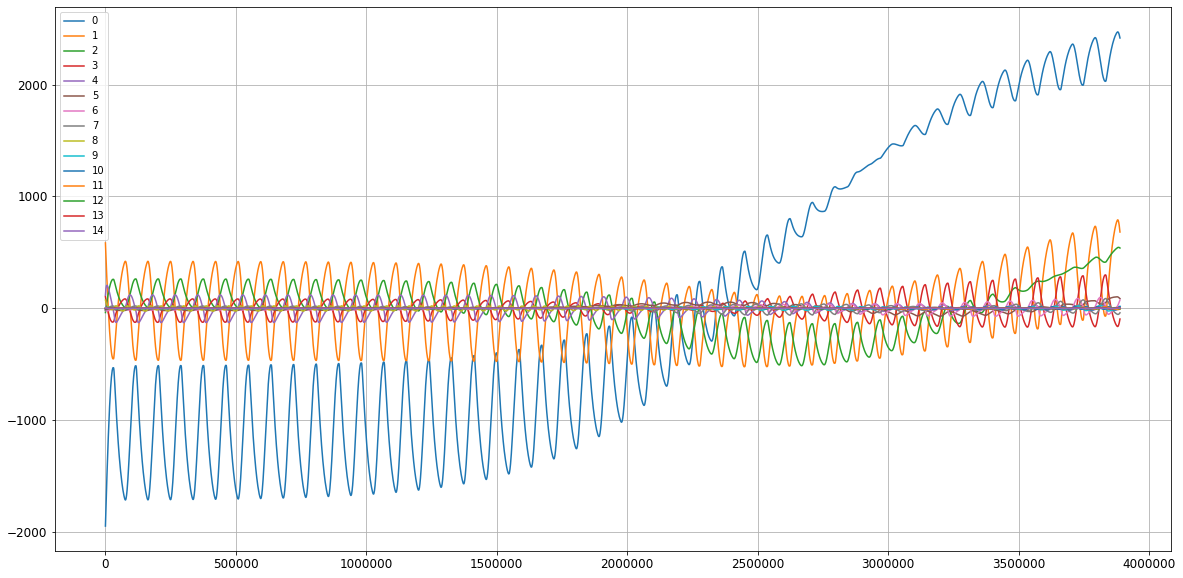

In [6]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_compressed);
ax.grid()
ax.legend(range(15))

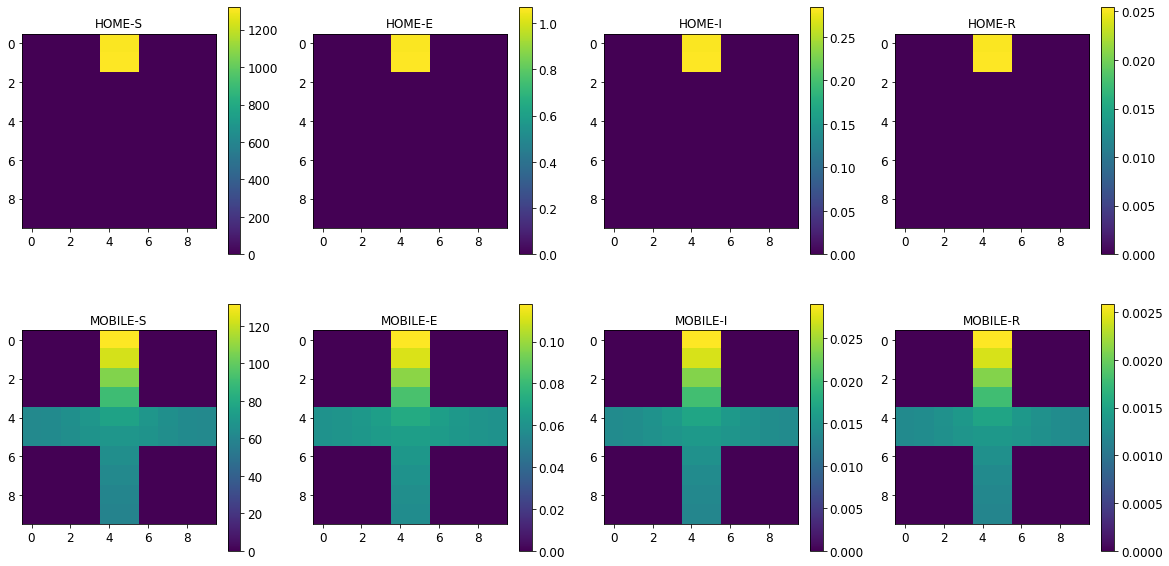

In [7]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

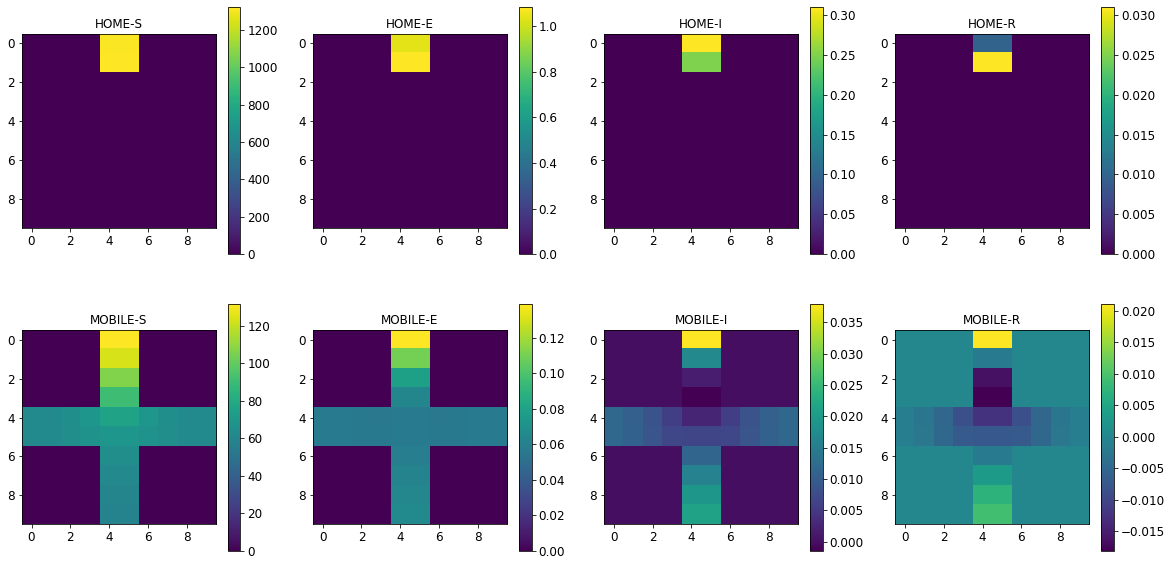

In [8]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

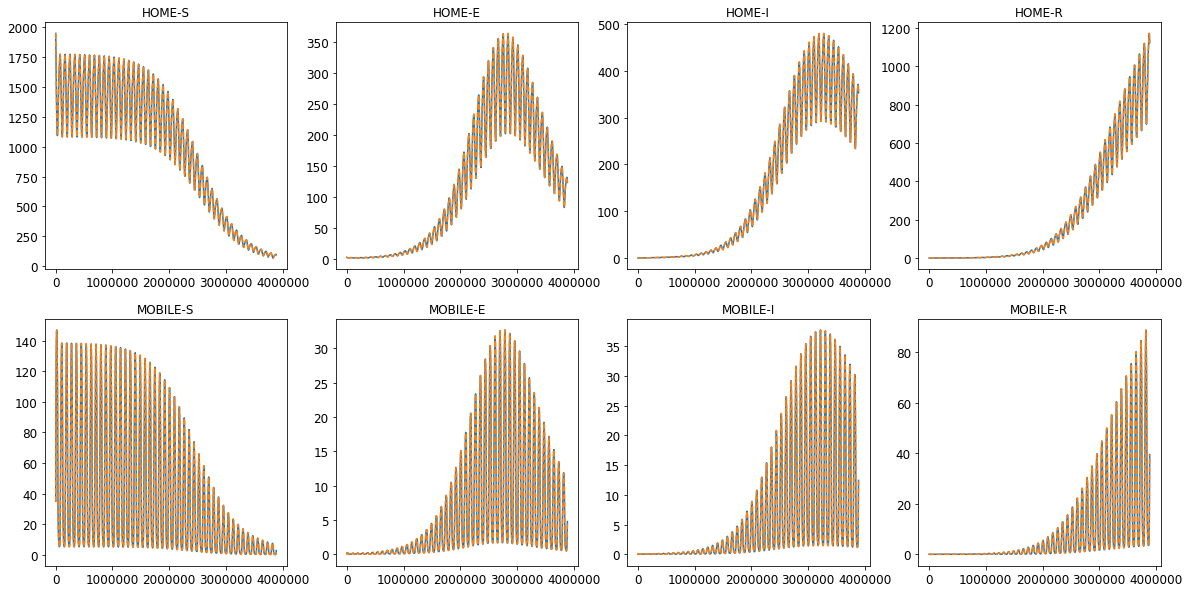

In [9]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_recovered[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

## Prepare data

In [10]:
codings_size = X_train_compressed.shape[1]
X_train_compressed.shape

(3888, 15)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1 
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [12]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [13]:
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print(X_train_concat.shape[0])
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

3798


(3798, 9, 15)


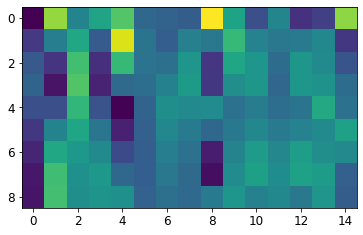

In [14]:
print(X_train_concat.shape)
plt.imshow(X_train_concat[0, :, :])

## Train the GAN

In [15]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
print(np.shape(X_train_concat))
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 9, 15, 1).astype('float32')
print(np.shape(train_dataset))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
print(len(X_train_concat))
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
print(type(train_dataset))
for data in train_dataset:
    print(data)
    break

(3798, 9, 15)
(3798, 9, 15, 1)
3798
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(
[[[[-0.79381007]
   [ 0.21031797]
   [ 0.03886965]
   ...
   [-0.2406737 ]
   [-0.11980895]
   [-0.23124874]]

  [[-0.59638697]
   [-0.28467476]
   [ 0.22081959]
   ...
   [-0.09871262]
   [-0.19246069]
   [-0.21947868]]

  [[-0.4103493 ]
   [-0.74484247]
   [ 0.38735417]
   ...
   [ 0.05593868]
   [-0.1575512 ]
   [-0.1833565 ]]

  ...

  [[-0.77132374]
   [ 0.17443578]
   [ 0.03952885]
   ...
   [ 0.06564569]
   [-0.0554887 ]
   [-0.05660066]]

  [[-0.845979  ]
   [ 0.3603532 ]
   [-0.0291043 ]
   ...
   [ 0.09723105]
   [ 0.08137865]
   [-0.37122878]]

  [[-0.8616456 ]
   [ 0.39413422]
   [-0.03988782]
   ...
   [-0.17903224]
   [ 0.08448455]
   [-0.44037634]]]


 [[[ 0.46716544]
   [-0.06459063]
   [-0.7599924 ]
   ...
   [ 0.4344609 ]
   [-0.21647902]
   [-0.2638511 ]]

  [[ 0.47569767]
   [-0.39826062]
   [-0.53709733]
   ...
   [ 0.11609684]
   [-0.60460734]
   [-0.370494

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*4*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((5, 4, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [17]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5120)              512000    
_________________________________________________________________
batch_normalization (BatchNo (None, 5120)              20480     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5120)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 4, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 4, 128)         0

(1, 9, 15, 1)


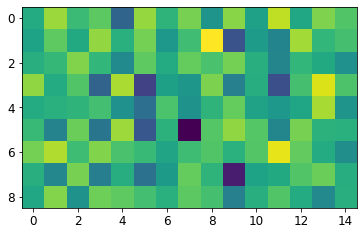

In [18]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [19]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[9, 15, 1]))
    # model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    # model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    # could swap dropout and flatten layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [20]:
critic = make_critic_model()
critic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 8, 64)          640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)             

In [21]:
decision = critic(generated_image)
print (decision)

tf.Tensor([[0.00396332]], shape=(1, 1), dtype=float32)


In [22]:
#gan = keras.models.Sequential([generator, discriminator])
wgan = keras.models.Sequential([generator, critic])

In [23]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

def critic_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss


# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
critic_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [24]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [25]:
def gradient_penalty(real, fake):
    """
    WGAN-GP uses gradient penalty instead of the weight
    clipping to enforce the Lipschitz constraint.
    """

    # alpha = tf.random.normal([self.BATCH_SIZE, self.n_var], mean=0.0, stddev=0.1)
    if real.shape[0]==BATCH_SIZE:
        alpha = tf.random.uniform(shape=[BATCH_SIZE, 9, 15, 1], minval=-1., maxval=1.)
    else:
        alpha = tf.random.uniform(shape=[real.shape[0]%BATCH_SIZE, 9, 15, 1], minval=-1., maxval=1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as t:
        t.watch(interpolated)
        pred = critic(interpolated, training=True)
    grad = t.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)
    gp = tf.reduce_mean((norm - 1.)**2)

    return gp


In [26]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [27]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + notebookName[:-6] + '/generator'
critic_log_dir = './logs/' + notebookName[:-6] + '/critic'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
critic_summary_writer = tf.summary.create_file_writer(critic_log_dir)

In [28]:
#@tf.function
def train_G(batch):
    """
    The training routine for the generator
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise, training=True)
        fake_output = critic(generated_data, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # return tf.math.abs(gen_loss)
    return gen_loss

In [29]:
#@tf.function
def train_D(batch):
    """
    The training routine for the critic
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = critic(batch, training=True)
        fake_output = critic(generated_data, training=True)

        disc_loss = critic_loss(real_output, fake_output)
        gp = gradient_penalty(batch, generated_data)
        # disc_loss += (self.critic_loss(real_output, fake_output) + gp*10.0)
        disc_loss += gp*10.0

    gradients_of_critic = disc_tape.gradient(disc_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

    # return tf.math.abs(disc_loss)
    return disc_loss

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
# def train_step(batch):
#     noise = tf.random.normal([BATCH_SIZE, latent_space])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         generated_images = generator(noise, training=True)

#         real_output = discriminator(batch, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#     generator_mean_loss(gen_loss)
#     discriminator_mean_loss(disc_loss)


In [36]:
# def train(dataset, epochs, scaler, scaled, X_train, y_train,n_critic=5):
def train(dataset, epochs, n_critic=5):
    """
    Training the WGAN-GP
    """

    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch, epochs))

        for batch in dataset:

            for _ in range(n_critic):
                train_D(batch)
                disc_loss = train_D(batch)
                critic_mean_loss(disc_loss)


            gen_loss = train_G(batch)
            generator_mean_loss(gen_loss)
            train_G(batch)

        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with critic_summary_writer.as_default():
            tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        hist.append([generator_mean_loss.result().numpy(), critic_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        critic_mean_loss.reset_states()

        print("critic", "{}: {:.6f}".format(critic.metrics_names[0], hist[-1][1]), end=' - ')
        print("generator", "{}: {:.6f}".format(wgan.metrics_names[0], hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%20 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
            X_generated = pca_compress.inverse_transform(X_generated)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.show() 

            # Save model
            wgan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()

    return hist


In [32]:
# def train(dataset, epochs):
#     hist = []
#     for epoch in range(epochs):
#         start = time.time()
#         print("Epoch {}/{}".format(epoch + 1, epochs))   

#         for batch in dataset:
#             train_step(batch)
            
#         with generator_summary_writer.as_default():
#             tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

#         with discriminator_summary_writer.as_default():
#             tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
#         hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

#         generator_mean_loss.reset_states()
#         discriminator_mean_loss.reset_states()
        
#         print("discriminator", "{}: {:.6f}".format(discriminator.metrics_names[0], hist[-1][1]), end=' - ')
#         print("generator", "{}: {:.6f}".format(gan.metrics_names[0], hist[-1][0]), end=' - ')    
#         print ('{:.0f}s'.format( time.time()-start))

#         # Global variables are used below
#         if epoch%1000 == 0: 
#             # Plot generated data
#             X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
#             X_generated = pca_compress.inverse_transform(X_generated)
#             X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
#             fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
#             for j in range(num_examples_to_generate):
#                 for i, group in enumerate(groups):
#                     for k in range(0,10,10): 
#                         ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
#                 for i, group in enumerate(groups):
#                     im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
#                     fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
#             plt.show() 
                    
#             # Save model
#             gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
#             # plot loss
#             print('Loss: ')
#             fig, ax = plt.subplots(1,1, figsize=[20,10])
#             ax.plot(hist)
#             ax.legend(['loss_gen', 'loss_disc'])
#             ax.set_yscale('log')
#             ax.grid()
#             plt.show()
            
#     return hist


Epoch 0/400
critic loss: -0.068623 - generator loss: -0.009770 - 36s


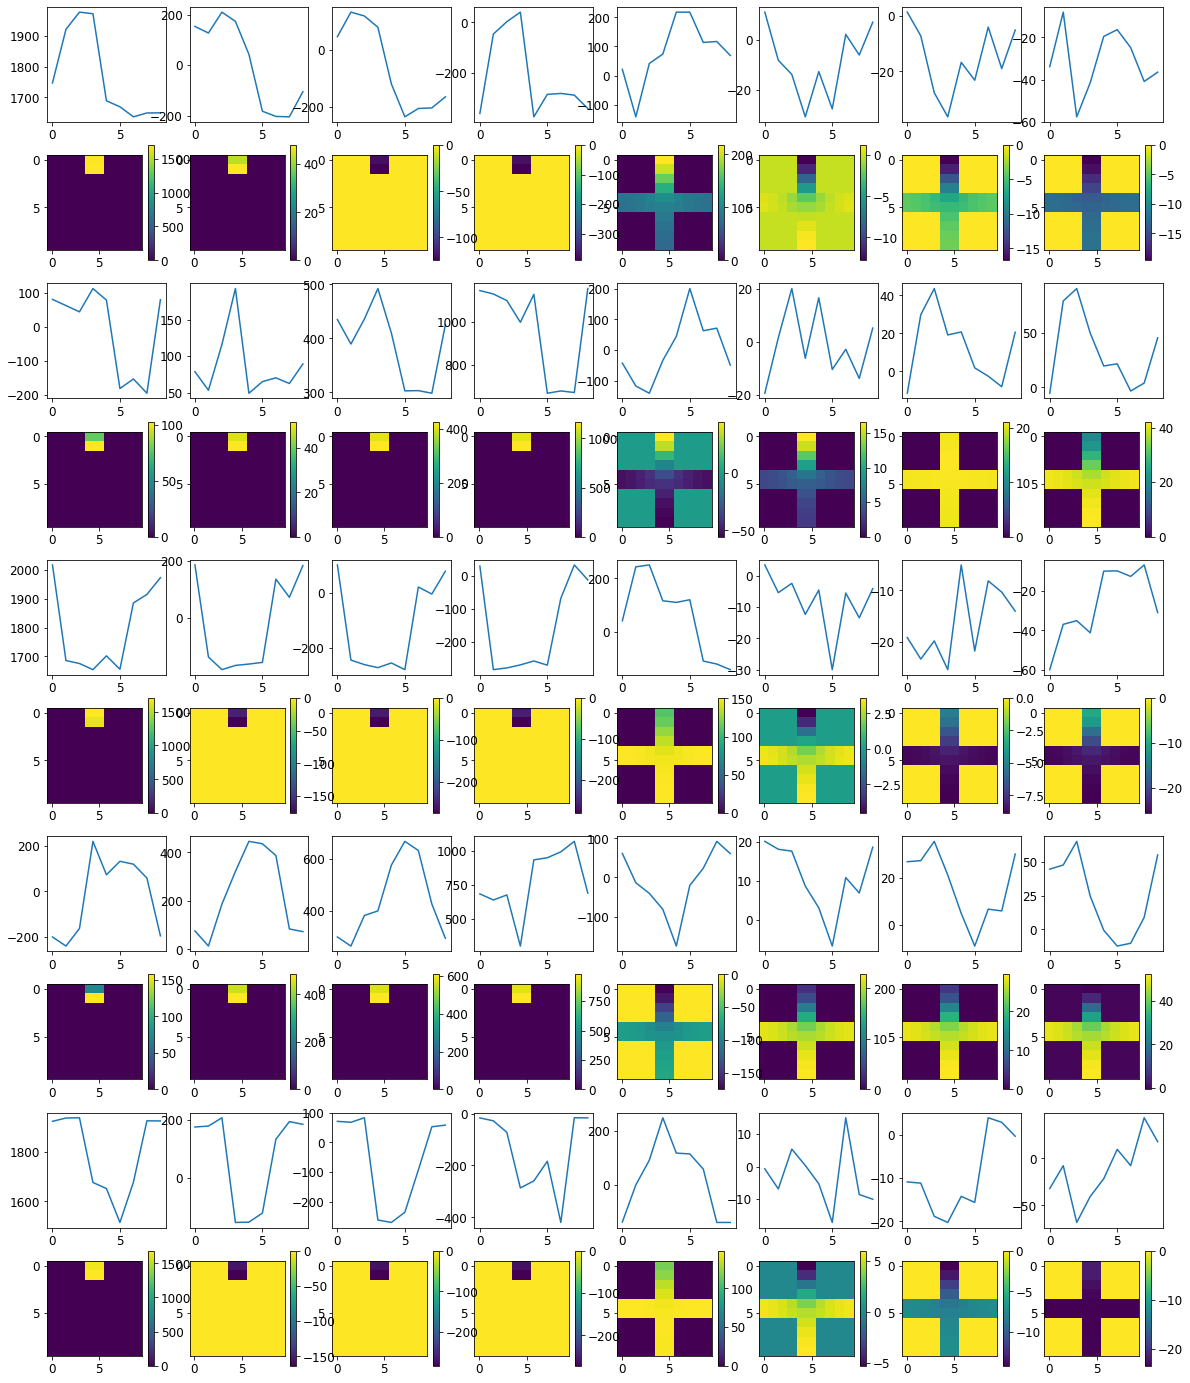

Loss: 


/home/nenko/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


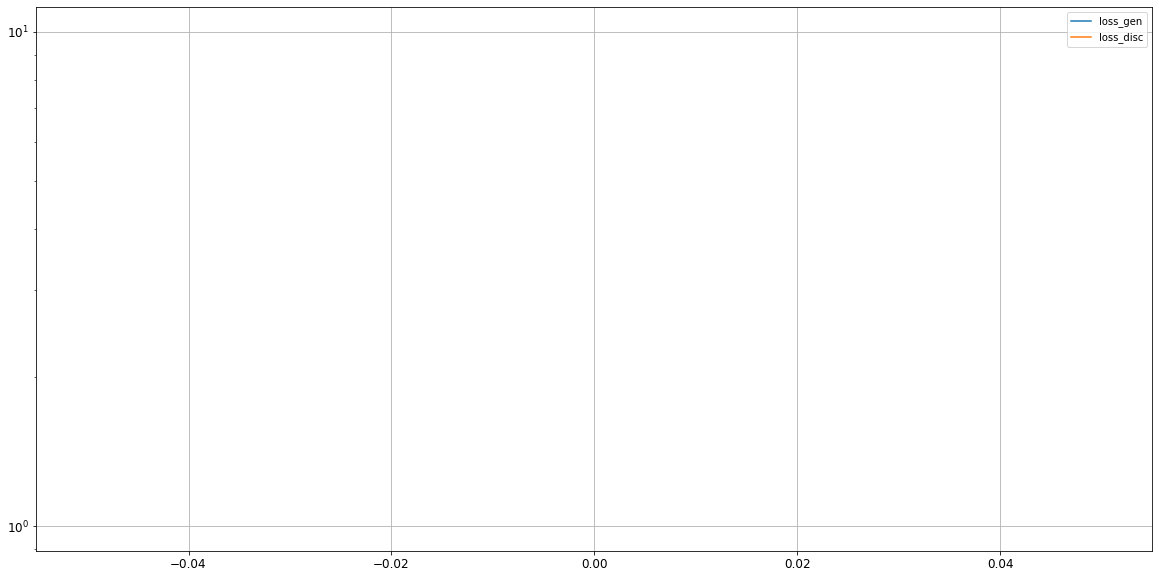

Epoch 1/400
critic loss: -0.076128 - generator loss: 0.001625 - 39s
Epoch 2/400
critic loss: -0.072142 - generator loss: 0.004115 - 39s
Epoch 3/400
critic loss: -0.067486 - generator loss: 0.000617 - 39s
Epoch 4/400
critic loss: -0.064834 - generator loss: 0.001764 - 39s
Epoch 5/400
critic loss: -0.061436 - generator loss: 0.002461 - 39s
Epoch 6/400
critic loss: -0.063034 - generator loss: 0.012321 - 40s
Epoch 7/400
critic loss: -0.060829 - generator loss: 0.022984 - 39s
Epoch 8/400
critic loss: -0.061508 - generator loss: 0.032755 - 39s
Epoch 9/400
critic loss: -0.061347 - generator loss: 0.047108 - 39s
Epoch 10/400
critic loss: -0.061100 - generator loss: 0.060213 - 40s
Epoch 11/400
critic loss: -0.062892 - generator loss: 0.071874 - 39s
Epoch 12/400
critic loss: -0.063640 - generator loss: 0.081780 - 39s
Epoch 13/400
critic loss: -0.062342 - generator loss: 0.092793 - 39s
Epoch 14/400
critic loss: -0.062881 - generator loss: 0.094999 - 39s
Epoch 15/400
critic loss: -0.063120 - gener

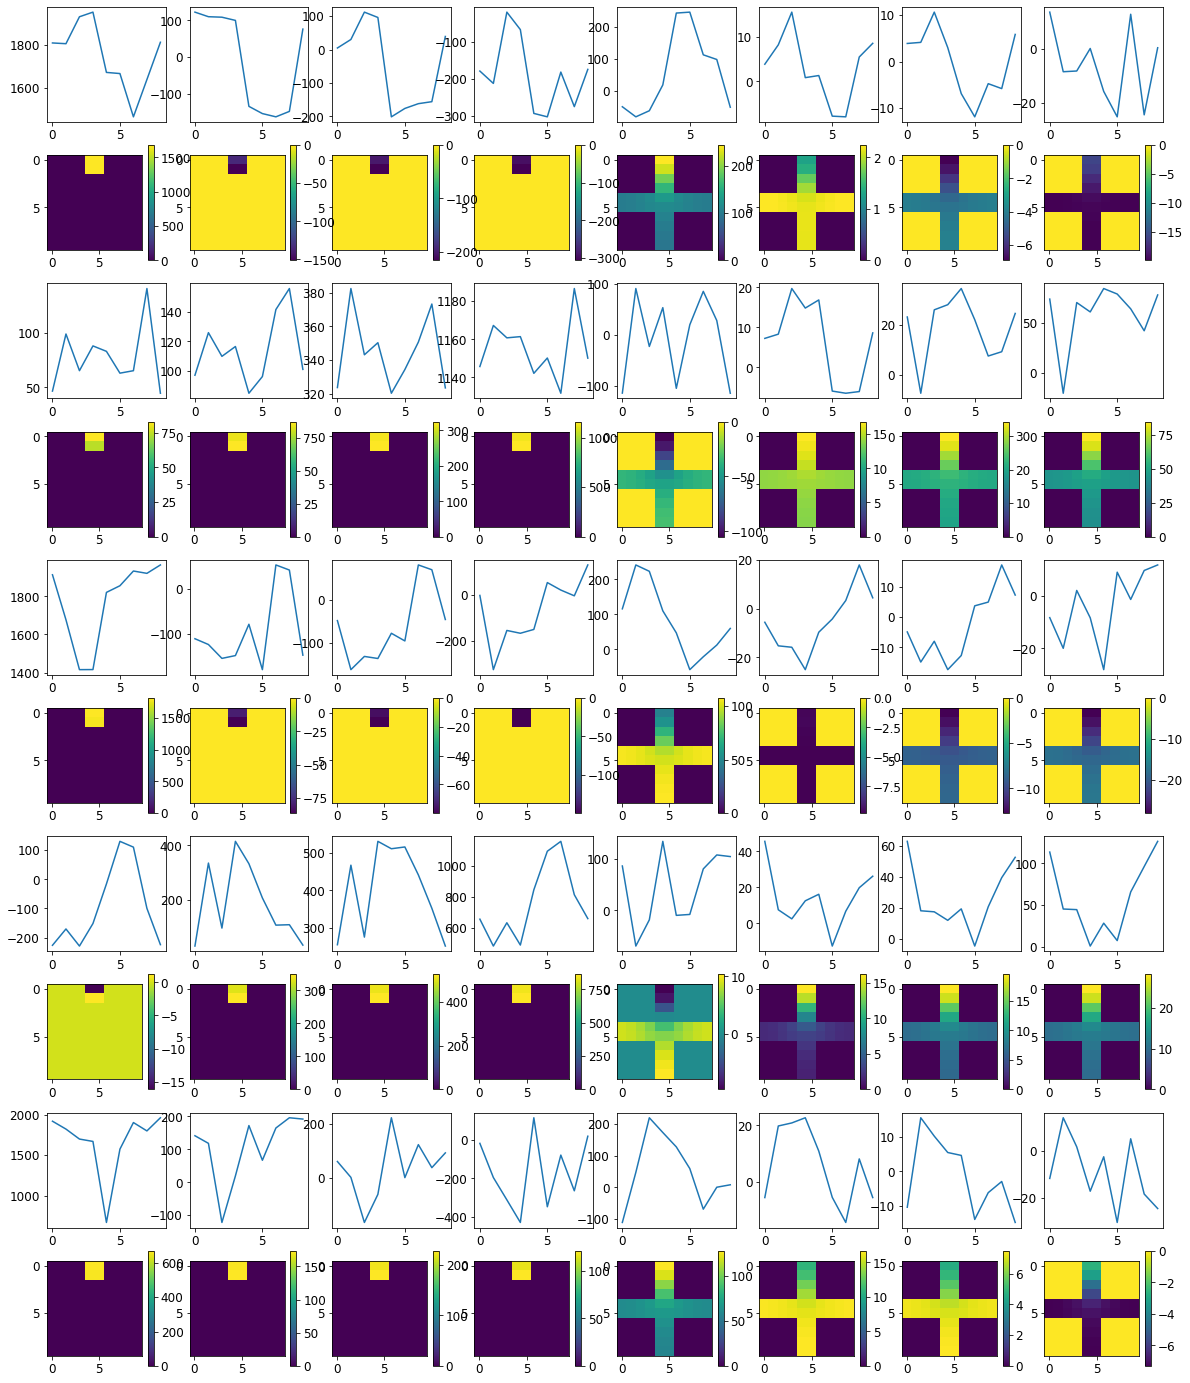

Loss: 


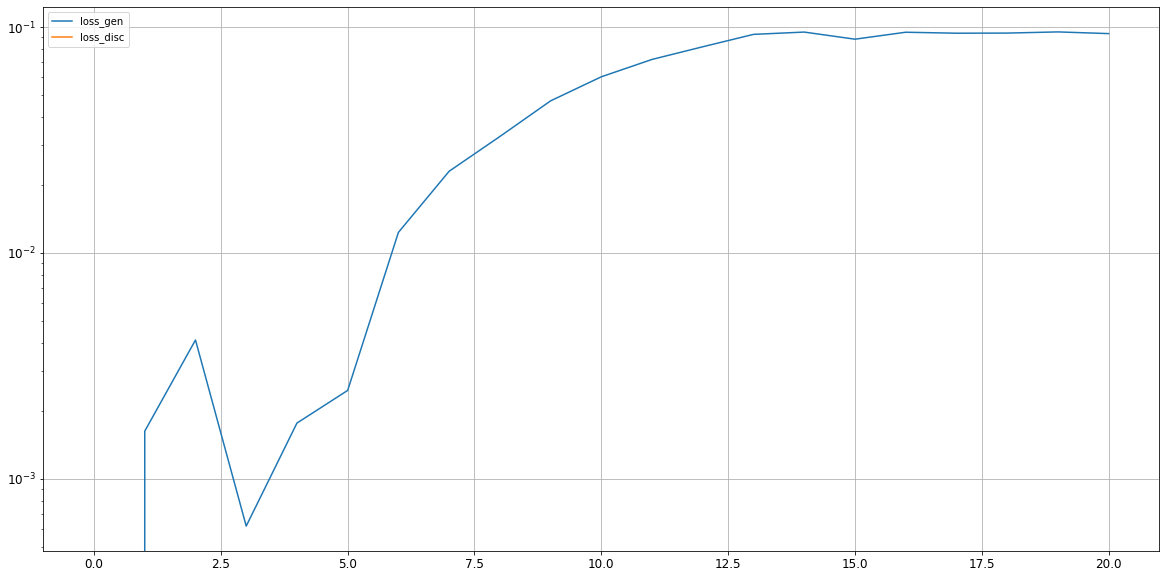

Epoch 21/400
critic loss: -0.061270 - generator loss: 0.089842 - 40s
Epoch 22/400
critic loss: -0.060457 - generator loss: 0.085555 - 39s
Epoch 23/400
critic loss: -0.059676 - generator loss: 0.081989 - 39s
Epoch 24/400
critic loss: -0.059102 - generator loss: 0.082101 - 39s
Epoch 25/400
critic loss: -0.057852 - generator loss: 0.079470 - 40s
Epoch 26/400
critic loss: -0.058193 - generator loss: 0.078536 - 39s
Epoch 27/400
critic loss: -0.057250 - generator loss: 0.078702 - 38s
Epoch 28/400
critic loss: -0.056182 - generator loss: 0.071730 - 39s
Epoch 29/400
critic loss: -0.055220 - generator loss: 0.070203 - 39s
Epoch 30/400
critic loss: -0.054430 - generator loss: 0.073482 - 39s
Epoch 31/400
critic loss: -0.054435 - generator loss: 0.073543 - 38s
Epoch 32/400
critic loss: -0.053884 - generator loss: 0.074825 - 40s
Epoch 33/400
critic loss: -0.052408 - generator loss: 0.070839 - 38s
Epoch 34/400
critic loss: -0.052220 - generator loss: 0.067715 - 39s
Epoch 35/400
critic loss: -0.05023

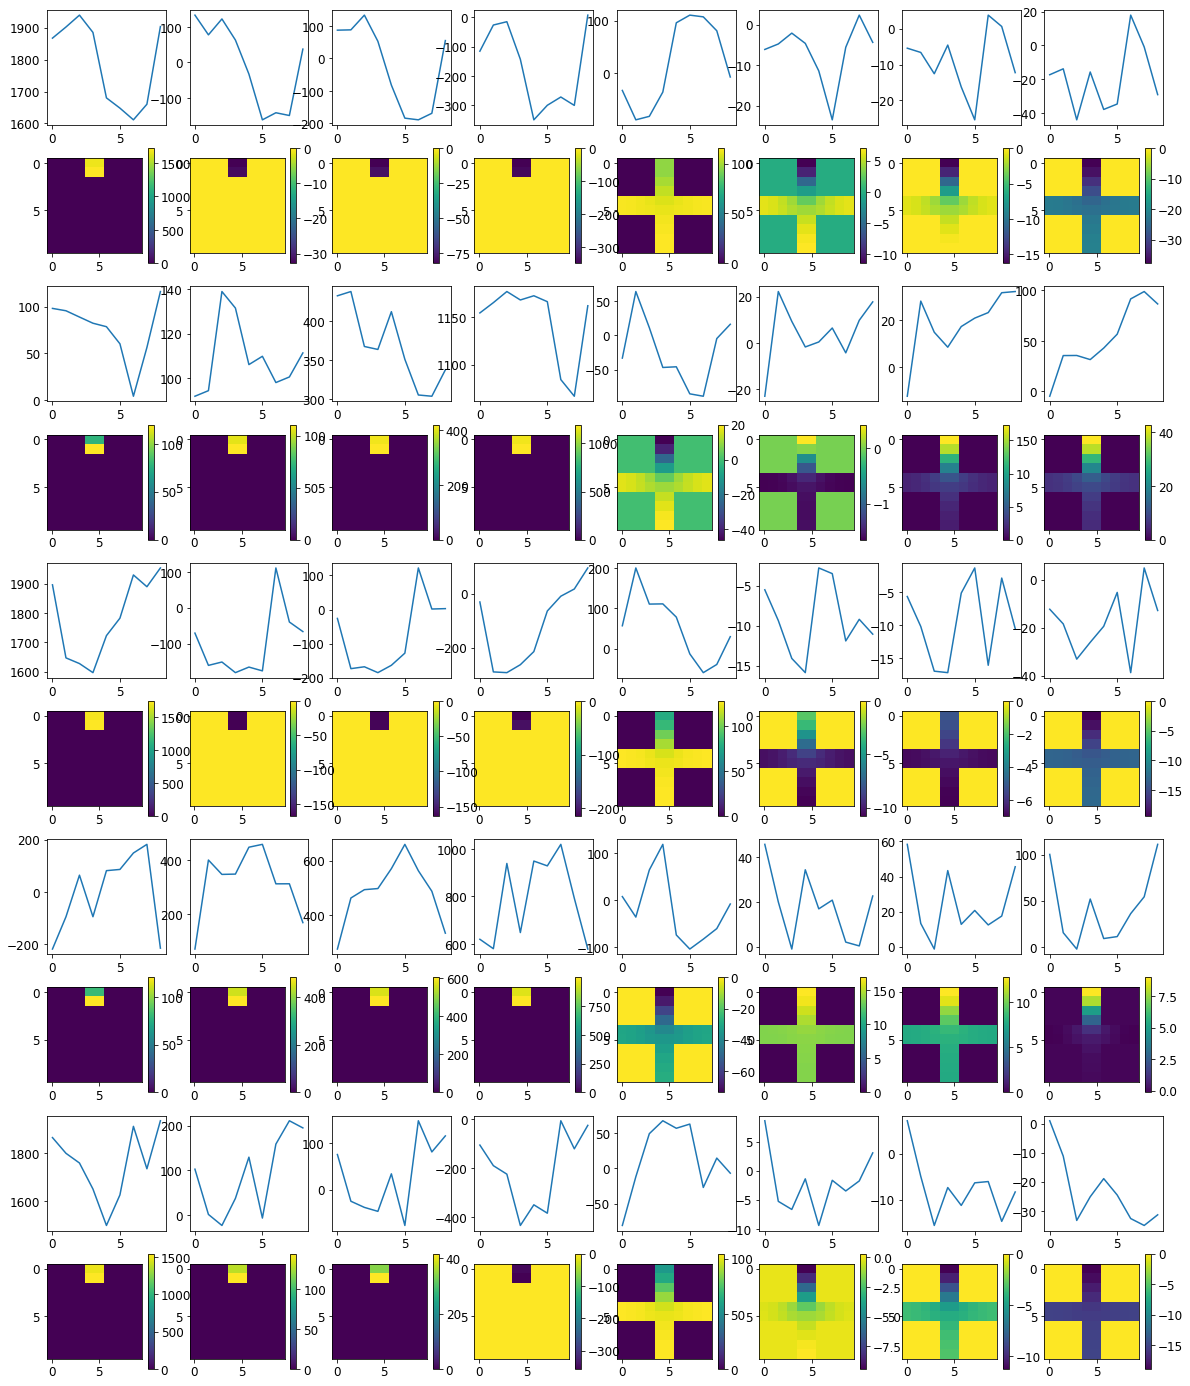

Loss: 


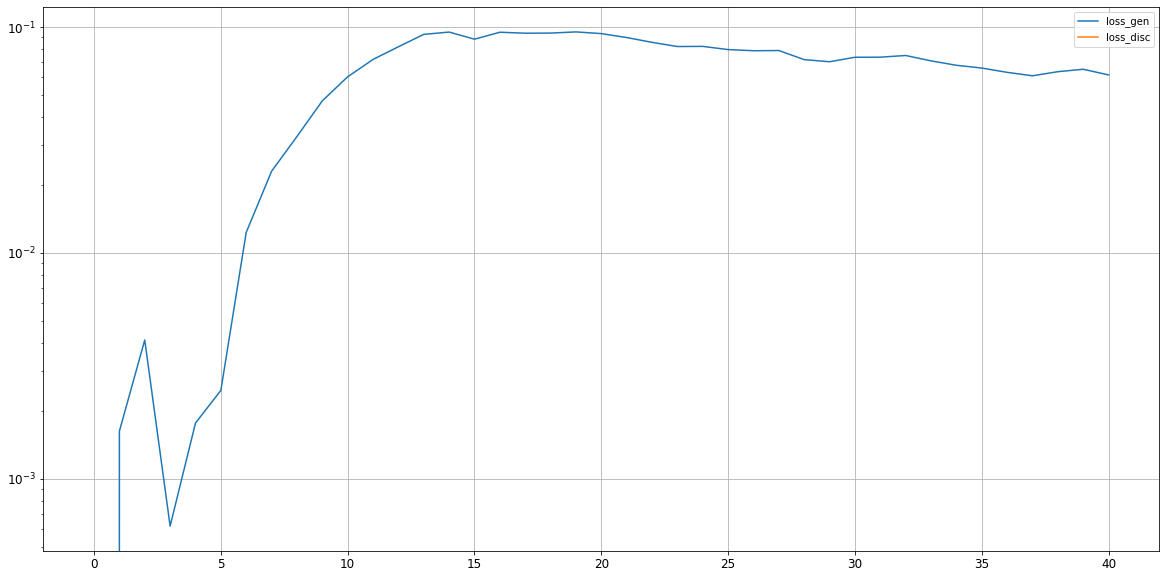

Epoch 41/400
critic loss: -0.047311 - generator loss: 0.063699 - 42s
Epoch 42/400
critic loss: -0.047699 - generator loss: 0.066232 - 41s
Epoch 43/400
critic loss: -0.047324 - generator loss: 0.066035 - 39s
Epoch 44/400
critic loss: -0.045799 - generator loss: 0.063572 - 41s
Epoch 45/400
critic loss: -0.044068 - generator loss: 0.064892 - 40s
Epoch 46/400
critic loss: -0.045111 - generator loss: 0.068413 - 40s
Epoch 47/400
critic loss: -0.043345 - generator loss: 0.063430 - 40s
Epoch 48/400
critic loss: -0.043640 - generator loss: 0.057946 - 39s
Epoch 49/400
critic loss: -0.044311 - generator loss: 0.063385 - 41s
Epoch 50/400
critic loss: -0.043412 - generator loss: 0.064748 - 41s
Epoch 51/400
critic loss: -0.042346 - generator loss: 0.064941 - 42s
Epoch 52/400
critic loss: -0.042579 - generator loss: 0.061885 - 43s
Epoch 53/400
critic loss: -0.041125 - generator loss: 0.062772 - 40s
Epoch 54/400
critic loss: -0.040759 - generator loss: 0.065256 - 44s
Epoch 55/400
critic loss: -0.04034

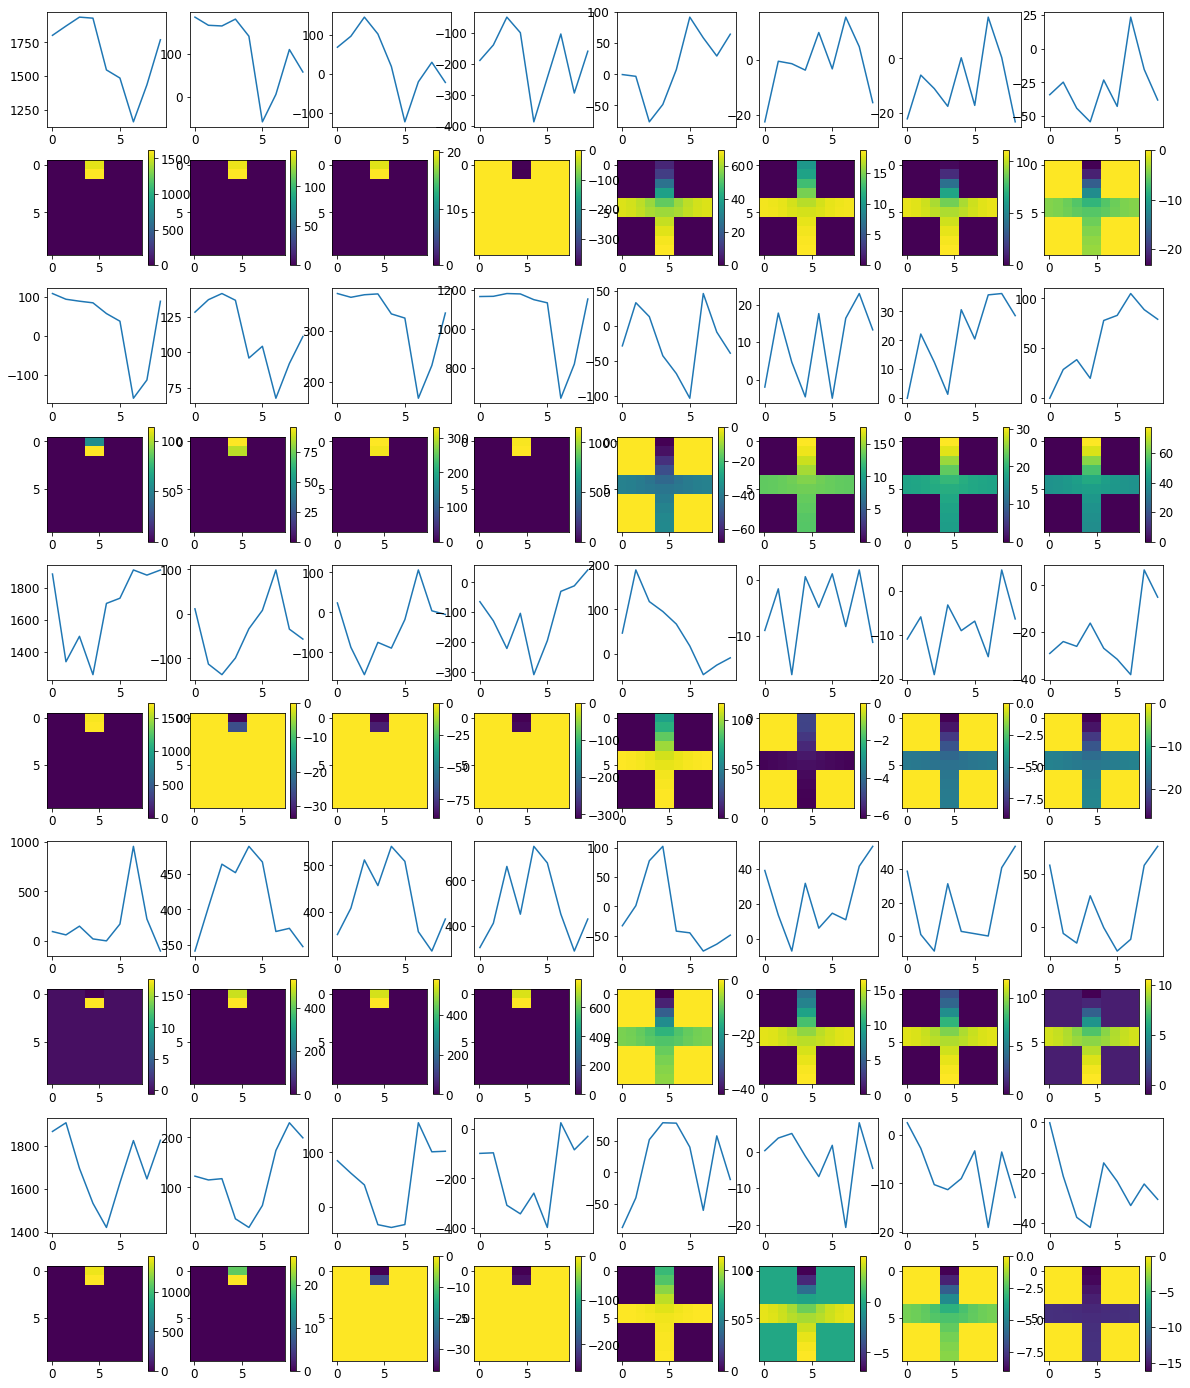

Loss: 


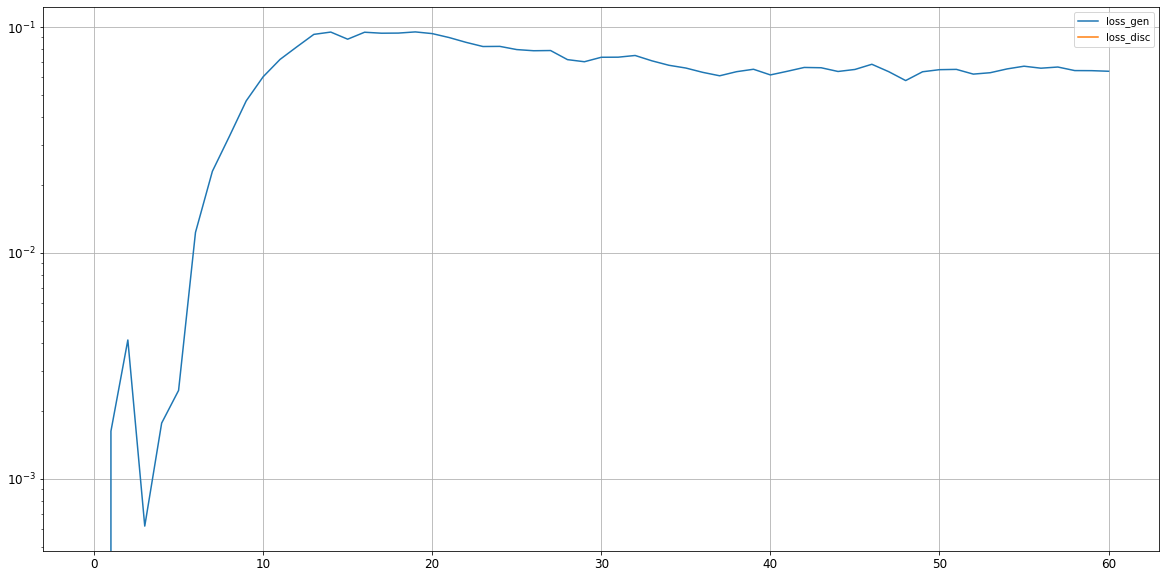

Epoch 61/400
critic loss: -0.037863 - generator loss: 0.065756 - 42s
Epoch 62/400
critic loss: -0.036864 - generator loss: 0.063315 - 42s
Epoch 63/400
critic loss: -0.034883 - generator loss: 0.066088 - 41s
Epoch 64/400
critic loss: -0.035858 - generator loss: 0.065076 - 40s
Epoch 65/400
critic loss: -0.035640 - generator loss: 0.062239 - 40s
Epoch 66/400
critic loss: -0.034616 - generator loss: 0.060622 - 39s
Epoch 67/400
critic loss: -0.034472 - generator loss: 0.058684 - 39s
Epoch 68/400
critic loss: -0.034469 - generator loss: 0.061536 - 39s
Epoch 69/400
critic loss: -0.035020 - generator loss: 0.065577 - 39s
Epoch 70/400
critic loss: -0.032637 - generator loss: 0.062705 - 39s
Epoch 71/400
critic loss: -0.033559 - generator loss: 0.061109 - 39s
Epoch 72/400
critic loss: -0.033064 - generator loss: 0.066240 - 39s
Epoch 73/400
critic loss: -0.031905 - generator loss: 0.068086 - 39s
Epoch 74/400
critic loss: -0.032022 - generator loss: 0.068487 - 40s
Epoch 75/400
critic loss: -0.03161

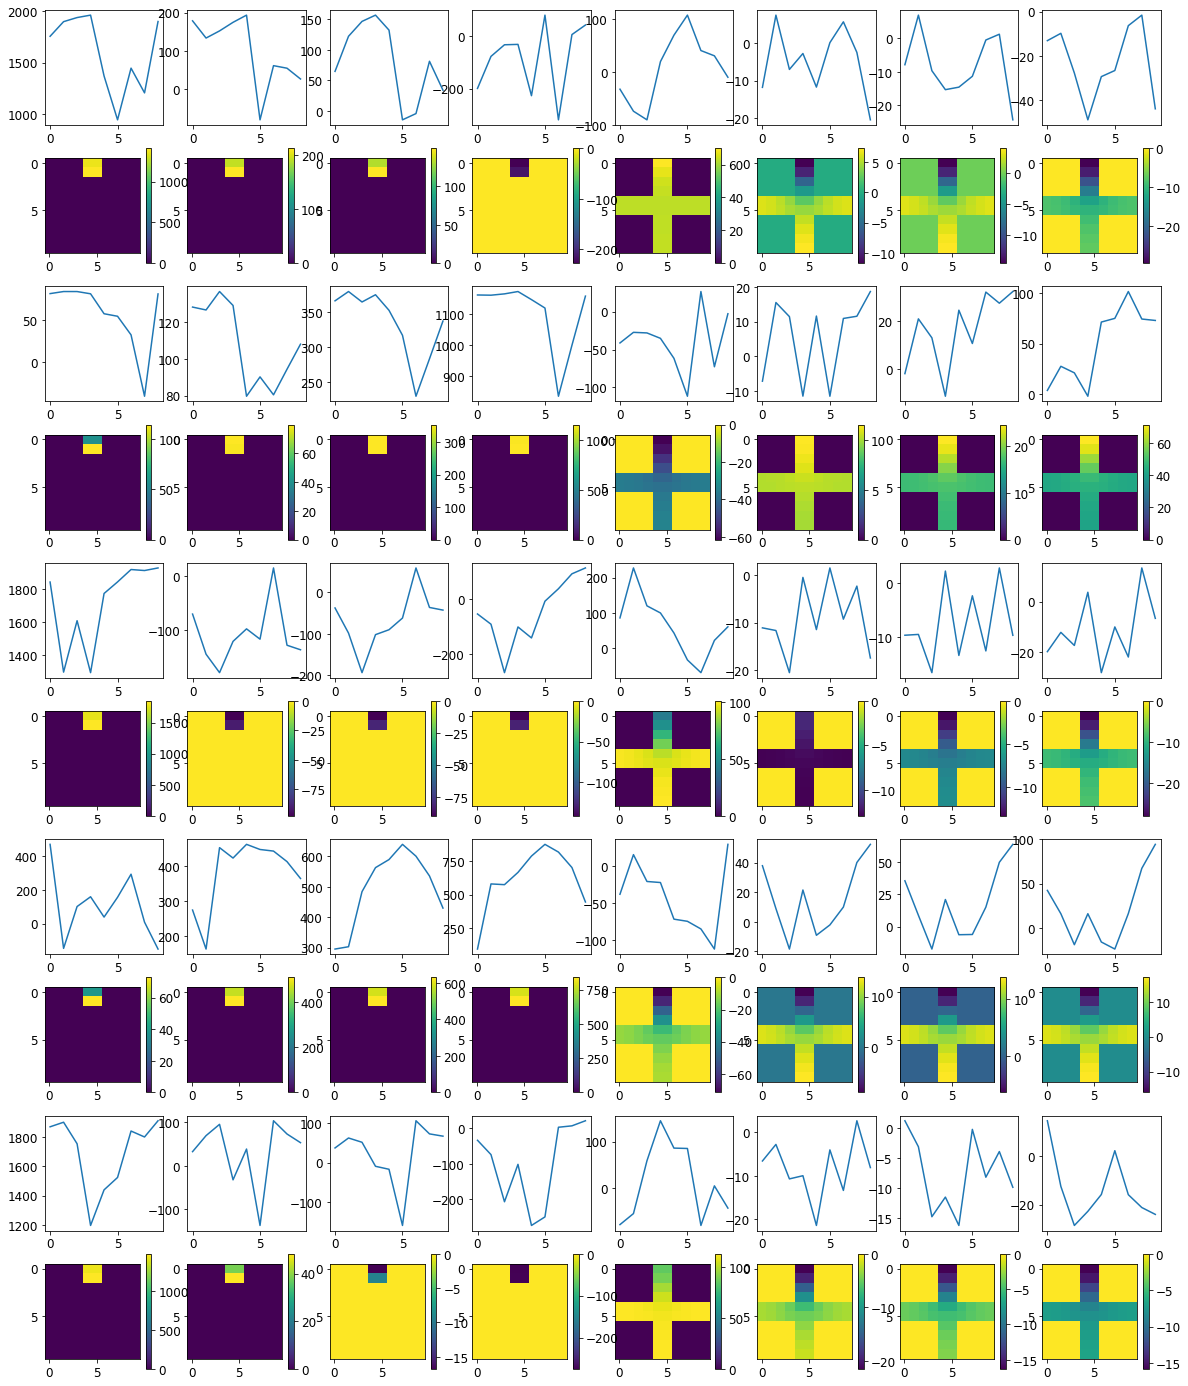

Loss: 


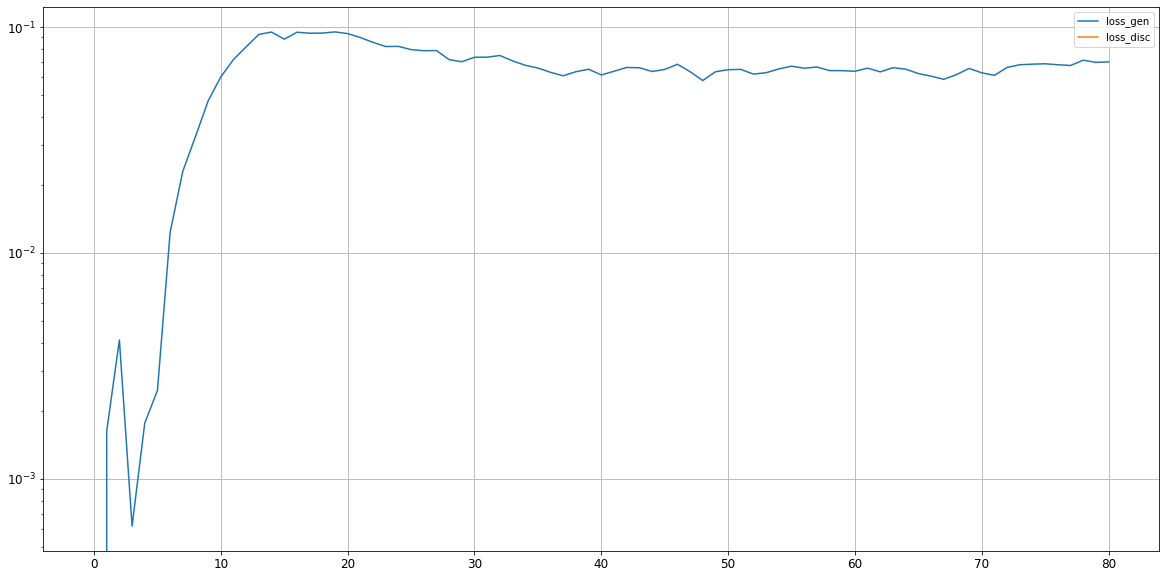

Epoch 81/400
critic loss: -0.030242 - generator loss: 0.076113 - 39s
Epoch 82/400
critic loss: -0.029586 - generator loss: 0.068695 - 39s
Epoch 83/400
critic loss: -0.028888 - generator loss: 0.067857 - 40s
Epoch 84/400
critic loss: -0.029531 - generator loss: 0.070972 - 38s
Epoch 85/400
critic loss: -0.027966 - generator loss: 0.073763 - 39s
Epoch 86/400
critic loss: -0.028417 - generator loss: 0.074244 - 39s
Epoch 87/400
critic loss: -0.027175 - generator loss: 0.071594 - 40s
Epoch 88/400
critic loss: -0.027431 - generator loss: 0.071011 - 39s
Epoch 89/400
critic loss: -0.027171 - generator loss: 0.071600 - 38s
Epoch 90/400
critic loss: -0.027697 - generator loss: 0.070232 - 39s
Epoch 91/400
critic loss: -0.026828 - generator loss: 0.069059 - 38s
Epoch 92/400
critic loss: -0.027121 - generator loss: 0.068925 - 39s
Epoch 93/400
critic loss: -0.027233 - generator loss: 0.068483 - 39s
Epoch 94/400
critic loss: -0.025772 - generator loss: 0.073793 - 39s
Epoch 95/400
critic loss: -0.02436

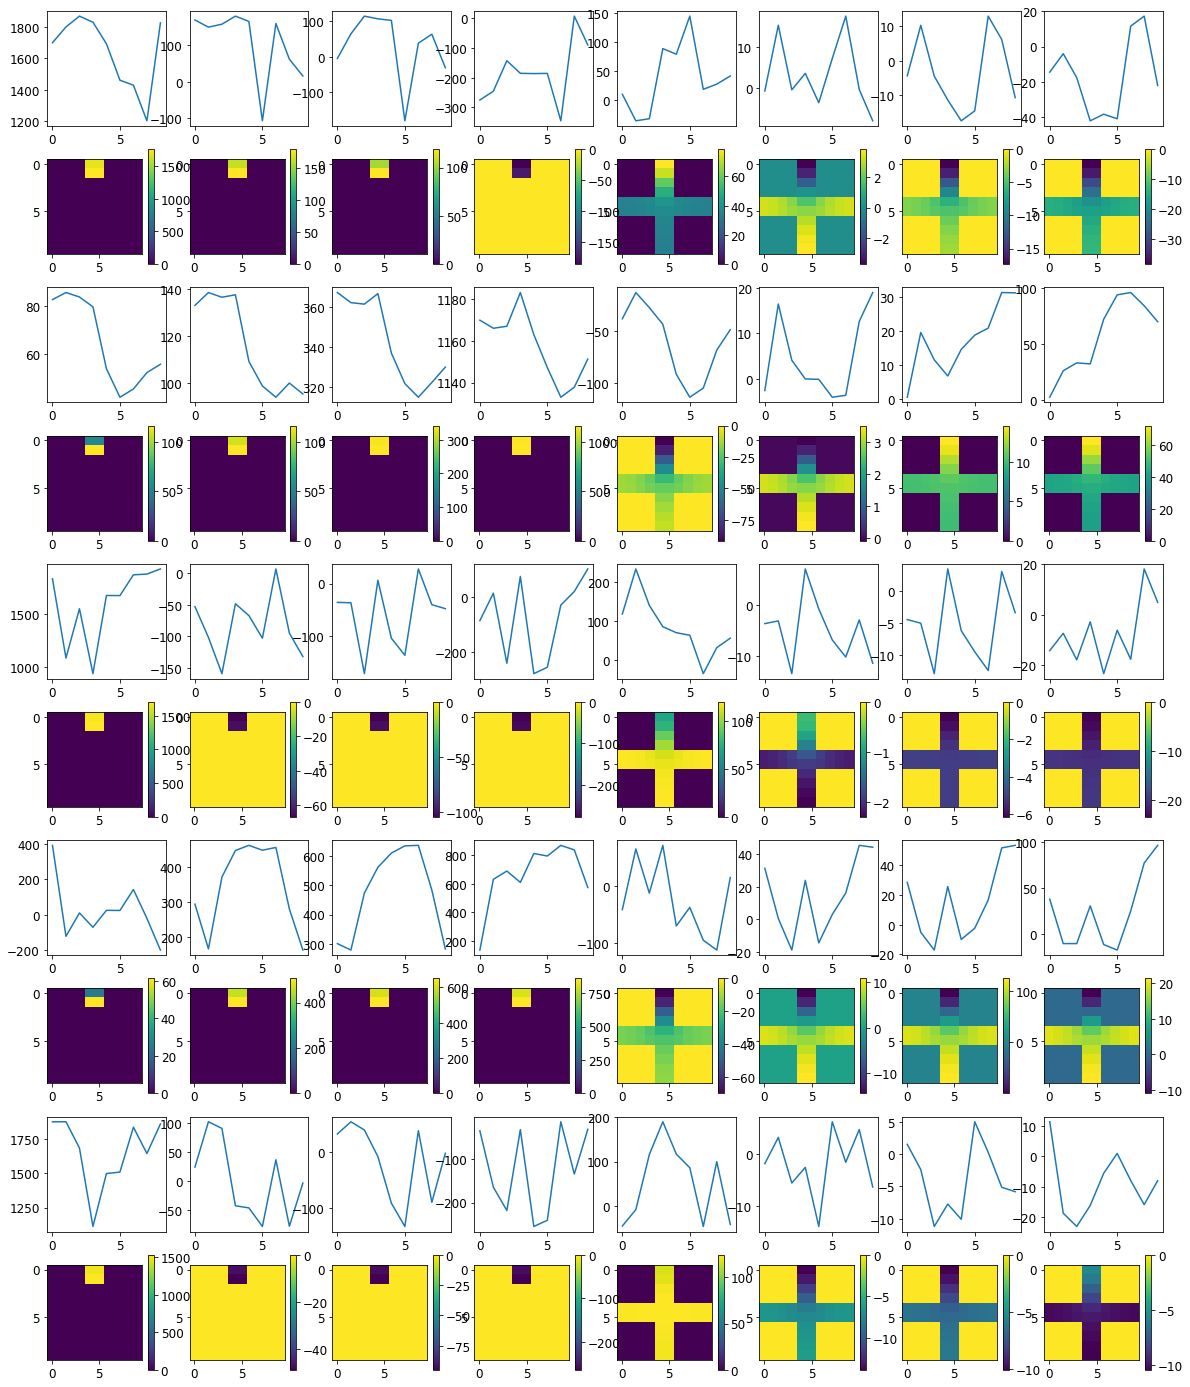

Loss: 


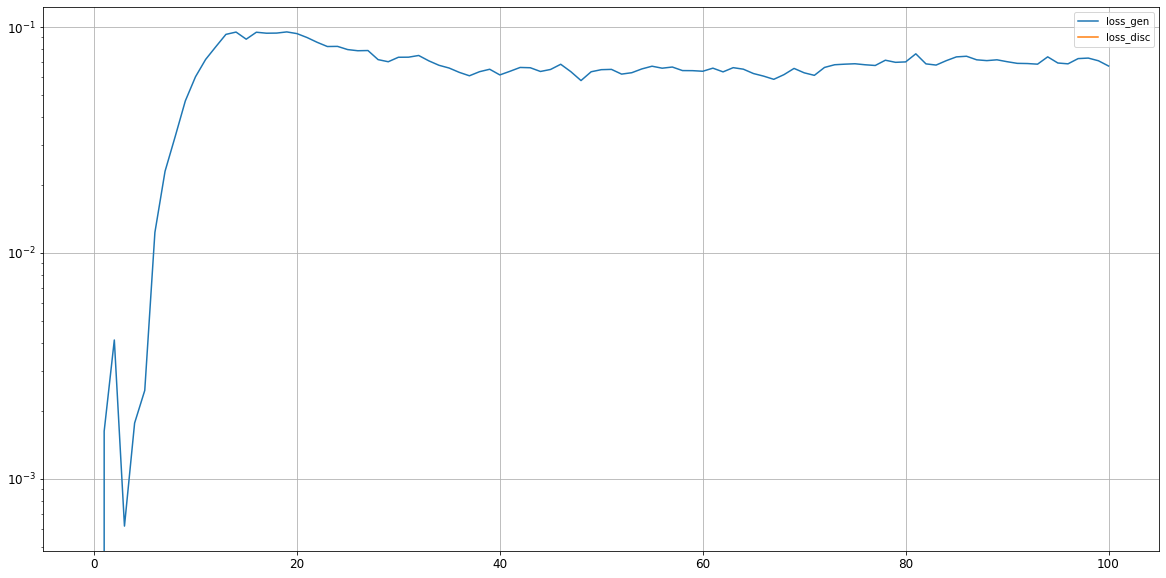

Epoch 101/400
critic loss: -0.022803 - generator loss: 0.070272 - 38s
Epoch 102/400
critic loss: -0.024841 - generator loss: 0.074704 - 39s
Epoch 103/400
critic loss: -0.022981 - generator loss: 0.078057 - 40s
Epoch 104/400
critic loss: -0.024678 - generator loss: 0.079687 - 39s
Epoch 105/400
critic loss: -0.024613 - generator loss: 0.080712 - 39s
Epoch 106/400
critic loss: -0.022721 - generator loss: 0.080819 - 39s
Epoch 107/400
critic loss: -0.022242 - generator loss: 0.076972 - 39s
Epoch 108/400
critic loss: -0.021694 - generator loss: 0.076997 - 40s
Epoch 109/400
critic loss: -0.023789 - generator loss: 0.080241 - 39s
Epoch 110/400
critic loss: -0.021500 - generator loss: 0.079486 - 38s
Epoch 111/400
critic loss: -0.021739 - generator loss: 0.081769 - 39s
Epoch 112/400
critic loss: -0.021948 - generator loss: 0.080612 - 39s
Epoch 113/400
critic loss: -0.020312 - generator loss: 0.082323 - 39s
Epoch 114/400
critic loss: -0.023090 - generator loss: 0.079252 - 39s
Epoch 115/400
critic

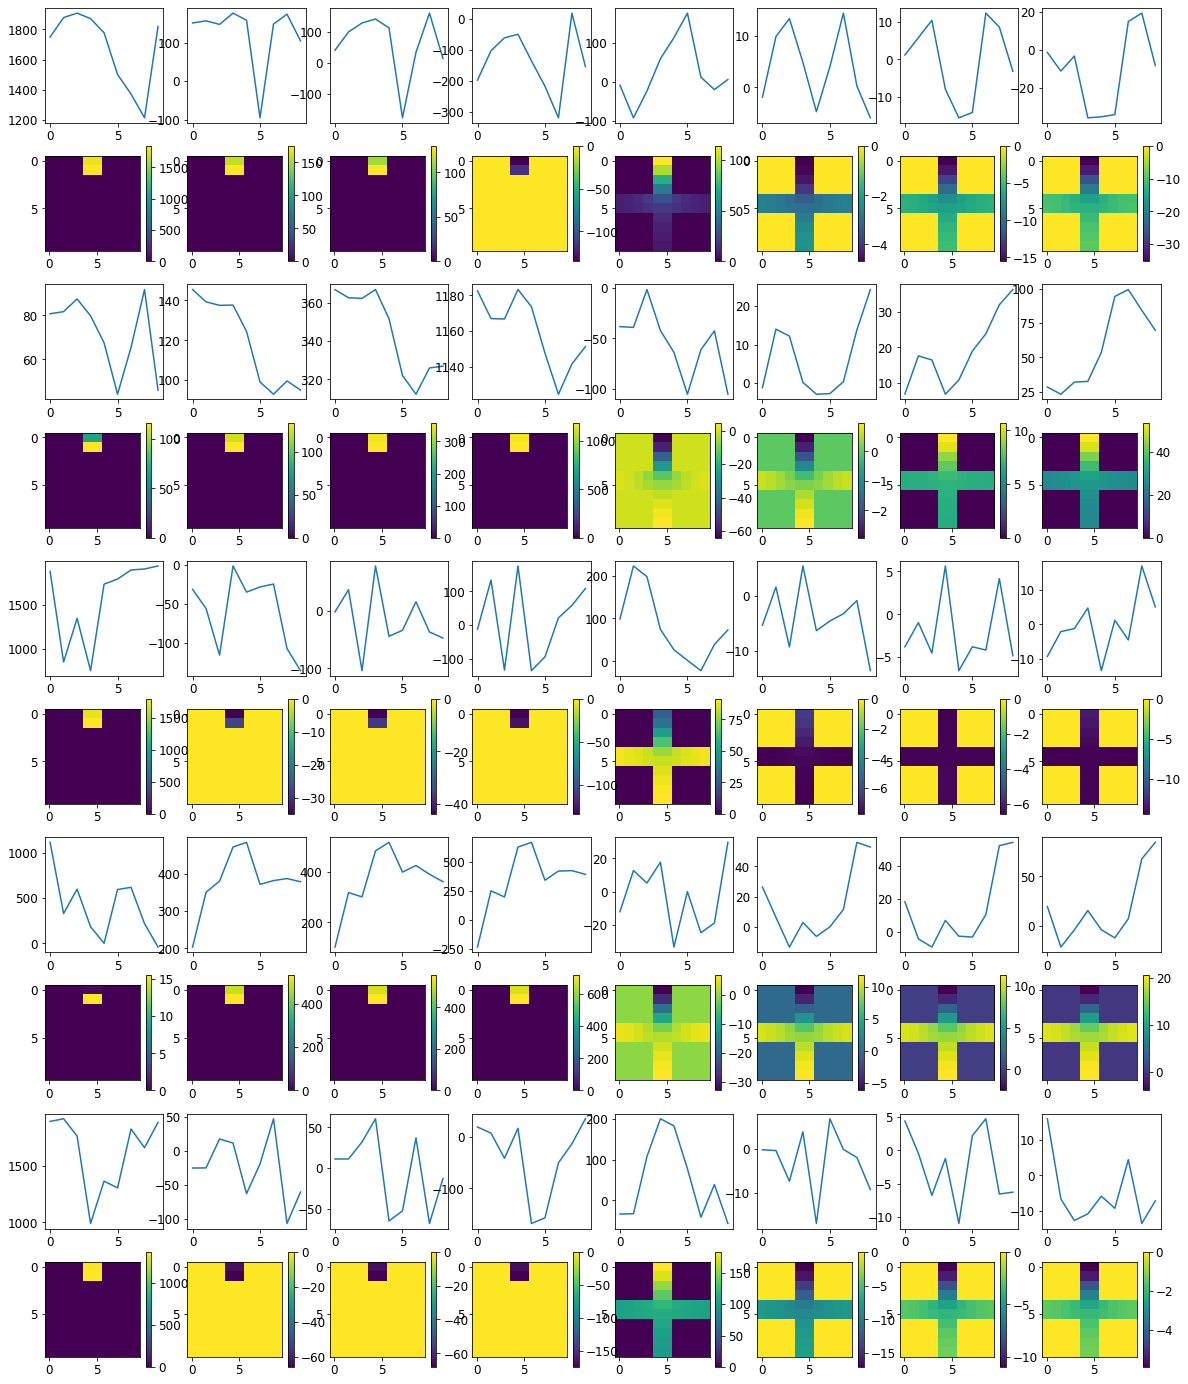

Loss: 


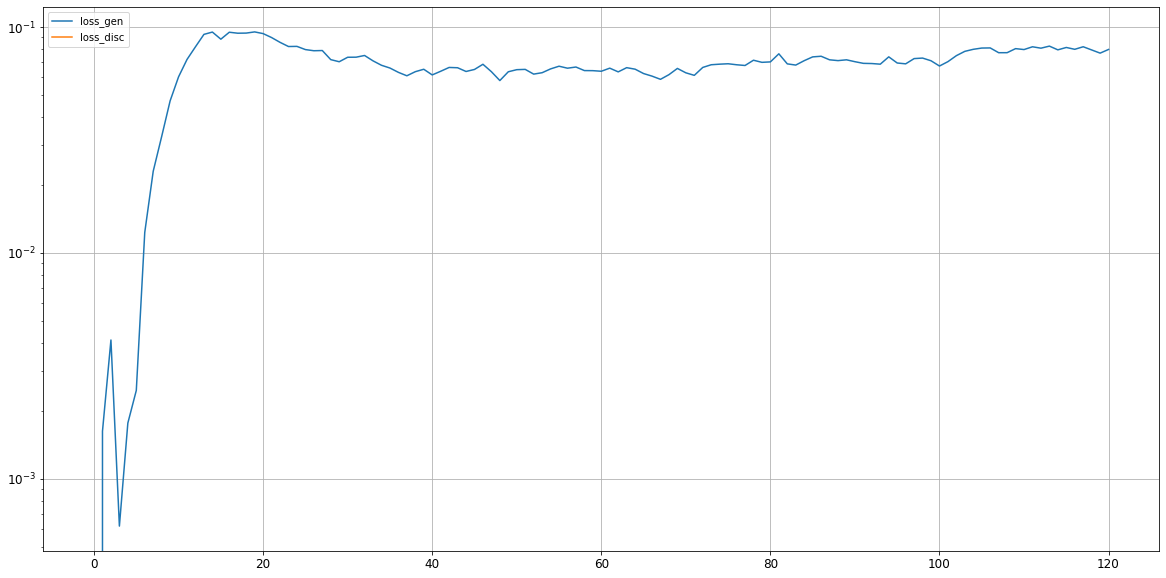

Epoch 121/400
critic loss: -0.020997 - generator loss: 0.083041 - 39s
Epoch 122/400
critic loss: -0.020844 - generator loss: 0.080755 - 38s
Epoch 123/400
critic loss: -0.020075 - generator loss: 0.080905 - 39s
Epoch 124/400
critic loss: -0.020445 - generator loss: 0.082966 - 39s
Epoch 125/400
critic loss: -0.020645 - generator loss: 0.083388 - 39s
Epoch 126/400
critic loss: -0.019363 - generator loss: 0.081808 - 39s
Epoch 127/400
critic loss: -0.020464 - generator loss: 0.081856 - 39s
Epoch 128/400
critic loss: -0.019455 - generator loss: 0.080249 - 39s
Epoch 129/400
critic loss: -0.019226 - generator loss: 0.079413 - 39s
Epoch 130/400
critic loss: -0.019729 - generator loss: 0.080915 - 40s
Epoch 131/400
critic loss: -0.018755 - generator loss: 0.081027 - 38s
Epoch 132/400
critic loss: -0.018289 - generator loss: 0.081381 - 39s
Epoch 133/400
critic loss: -0.017974 - generator loss: 0.075746 - 38s
Epoch 134/400
critic loss: -0.018518 - generator loss: 0.074475 - 39s
Epoch 135/400
critic

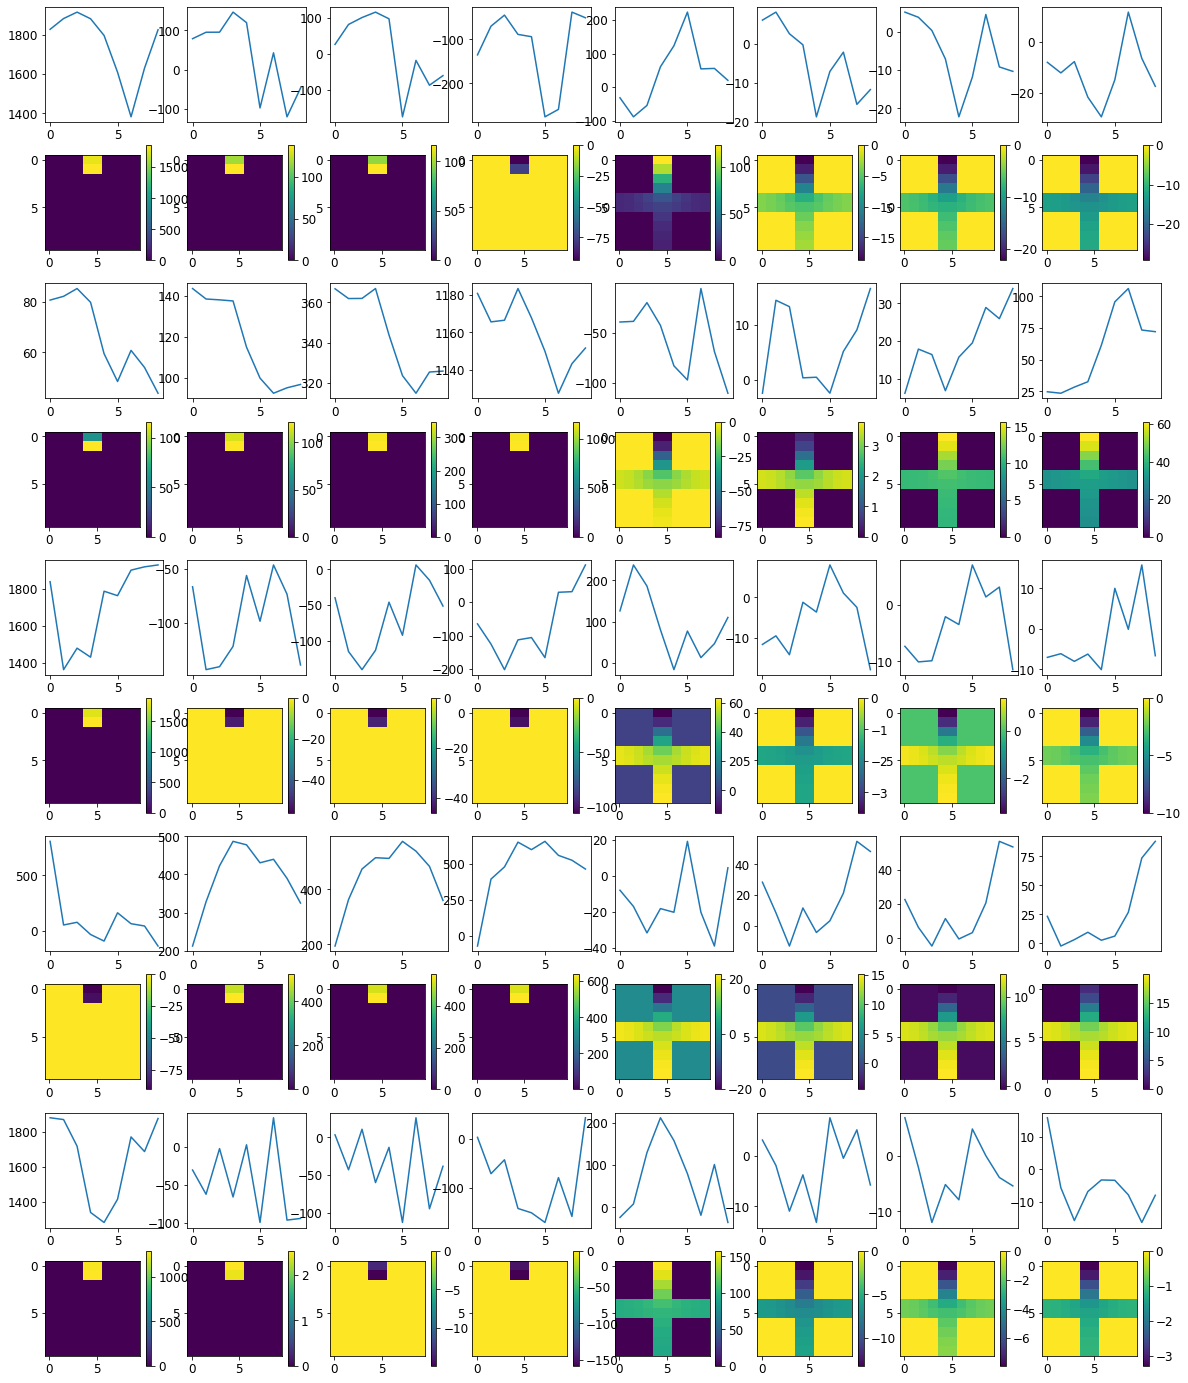

Loss: 


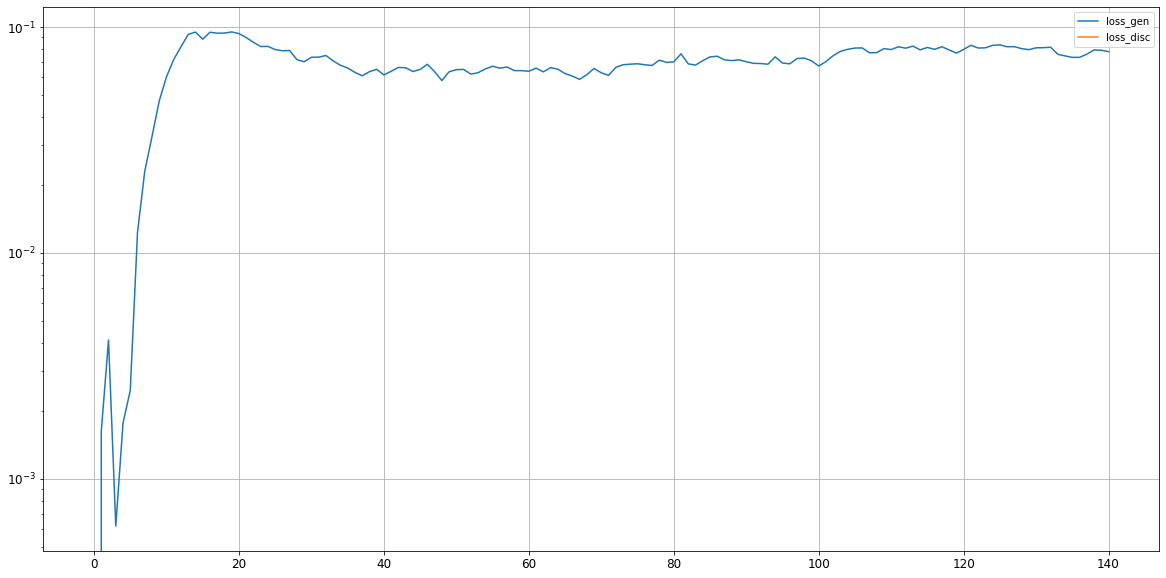

Epoch 141/400
critic loss: -0.018026 - generator loss: 0.080872 - 39s
Epoch 142/400
critic loss: -0.016929 - generator loss: 0.079779 - 39s
Epoch 143/400
critic loss: -0.018284 - generator loss: 0.081053 - 39s
Epoch 144/400
critic loss: -0.017592 - generator loss: 0.077540 - 40s
Epoch 145/400
critic loss: -0.017179 - generator loss: 0.074861 - 40s
Epoch 146/400
critic loss: -0.017509 - generator loss: 0.072806 - 39s
Epoch 147/400
critic loss: -0.016938 - generator loss: 0.074352 - 39s
Epoch 148/400
critic loss: -0.016408 - generator loss: 0.078475 - 40s
Epoch 149/400
critic loss: -0.016618 - generator loss: 0.077927 - 38s
Epoch 150/400
critic loss: -0.017907 - generator loss: 0.075462 - 39s
Epoch 151/400
critic loss: -0.015339 - generator loss: 0.077996 - 39s
Epoch 152/400
critic loss: -0.017052 - generator loss: 0.075467 - 39s
Epoch 153/400
critic loss: -0.015712 - generator loss: 0.075004 - 38s
Epoch 154/400
critic loss: -0.017874 - generator loss: 0.074005 - 39s
Epoch 155/400
critic

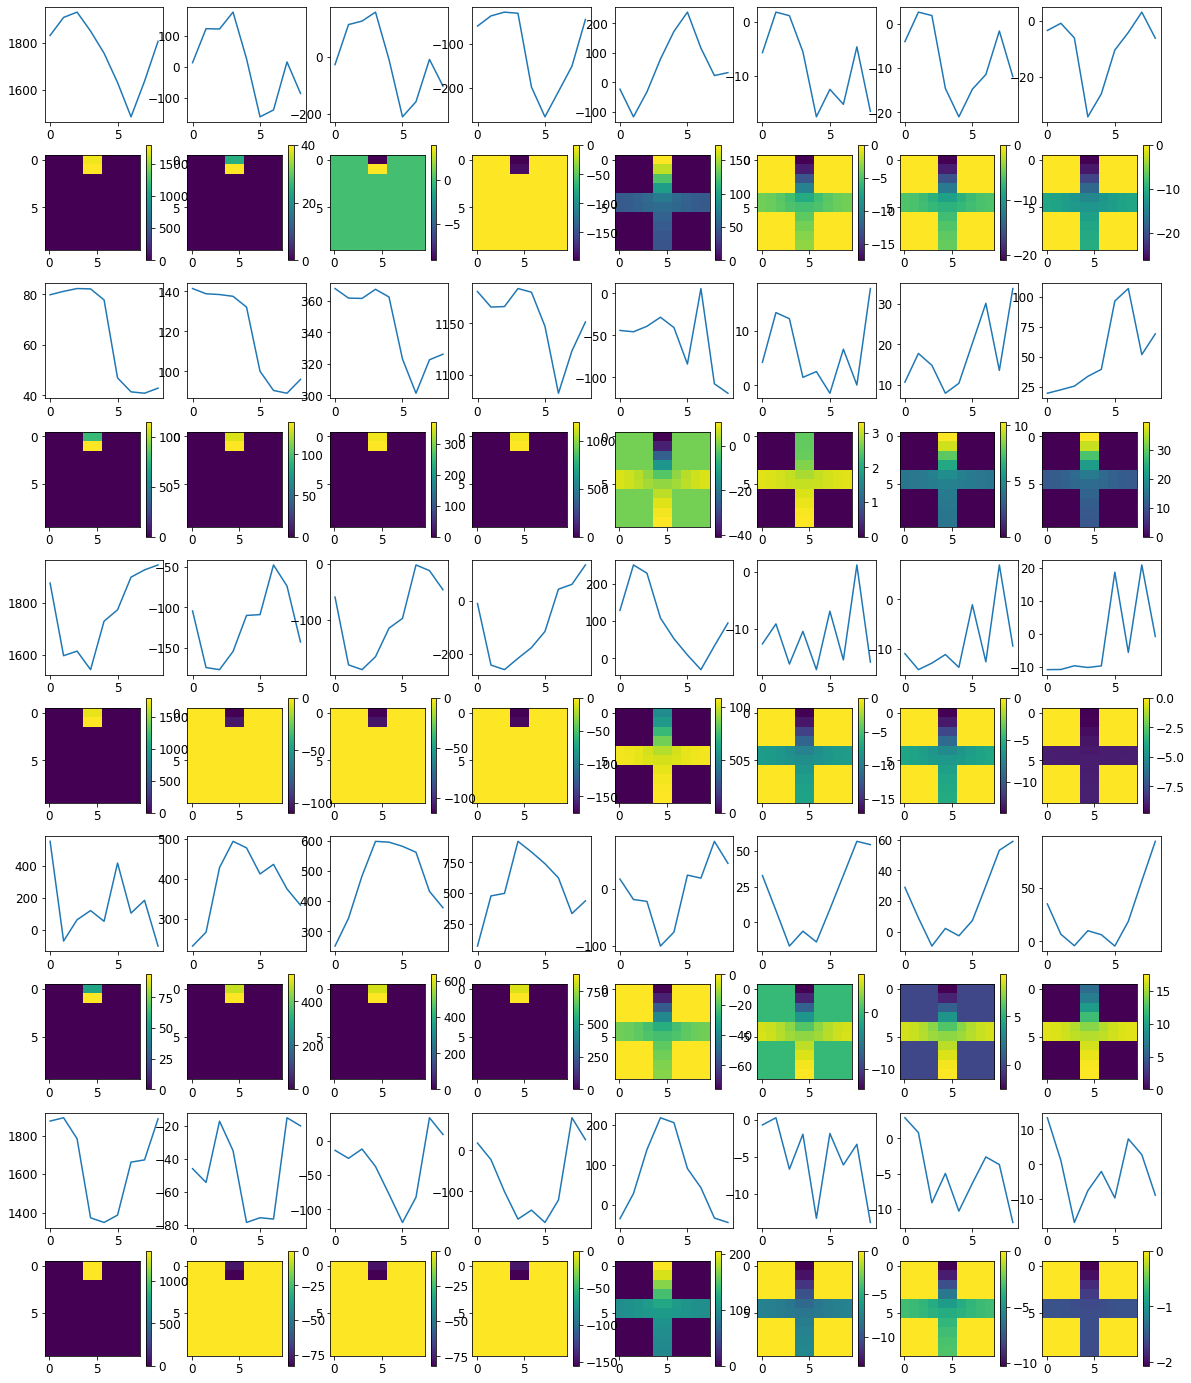

Loss: 


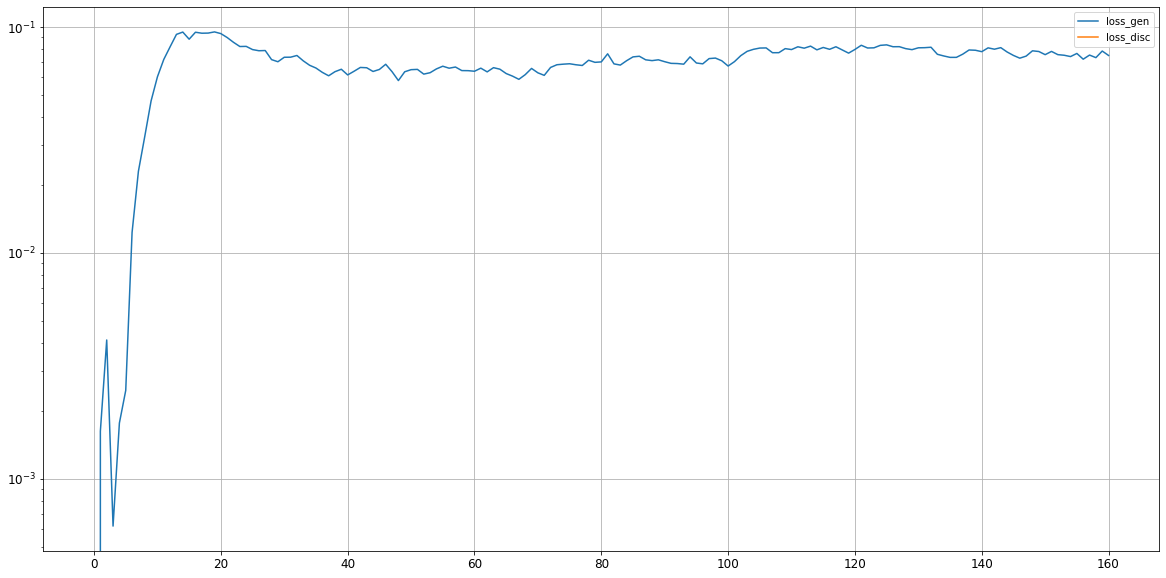

Epoch 161/400
critic loss: -0.015314 - generator loss: 0.079738 - 38s
Epoch 162/400
critic loss: -0.015600 - generator loss: 0.077444 - 38s
Epoch 163/400
critic loss: -0.016312 - generator loss: 0.077470 - 39s
Epoch 164/400
critic loss: -0.014141 - generator loss: 0.079965 - 39s
Epoch 165/400
critic loss: -0.014655 - generator loss: 0.079184 - 38s
Epoch 166/400
critic loss: -0.015827 - generator loss: 0.080501 - 39s
Epoch 167/400
critic loss: -0.014696 - generator loss: 0.073002 - 38s
Epoch 168/400
critic loss: -0.014773 - generator loss: 0.071267 - 40s
Epoch 169/400
critic loss: -0.014774 - generator loss: 0.076715 - 39s
Epoch 170/400
critic loss: -0.016100 - generator loss: 0.073087 - 39s
Epoch 171/400
critic loss: -0.014078 - generator loss: 0.064858 - 39s
Epoch 172/400
critic loss: -0.014885 - generator loss: 0.065599 - 40s
Epoch 173/400
critic loss: -0.013130 - generator loss: 0.063599 - 39s
Epoch 174/400
critic loss: -0.014600 - generator loss: 0.066712 - 38s
Epoch 175/400
critic

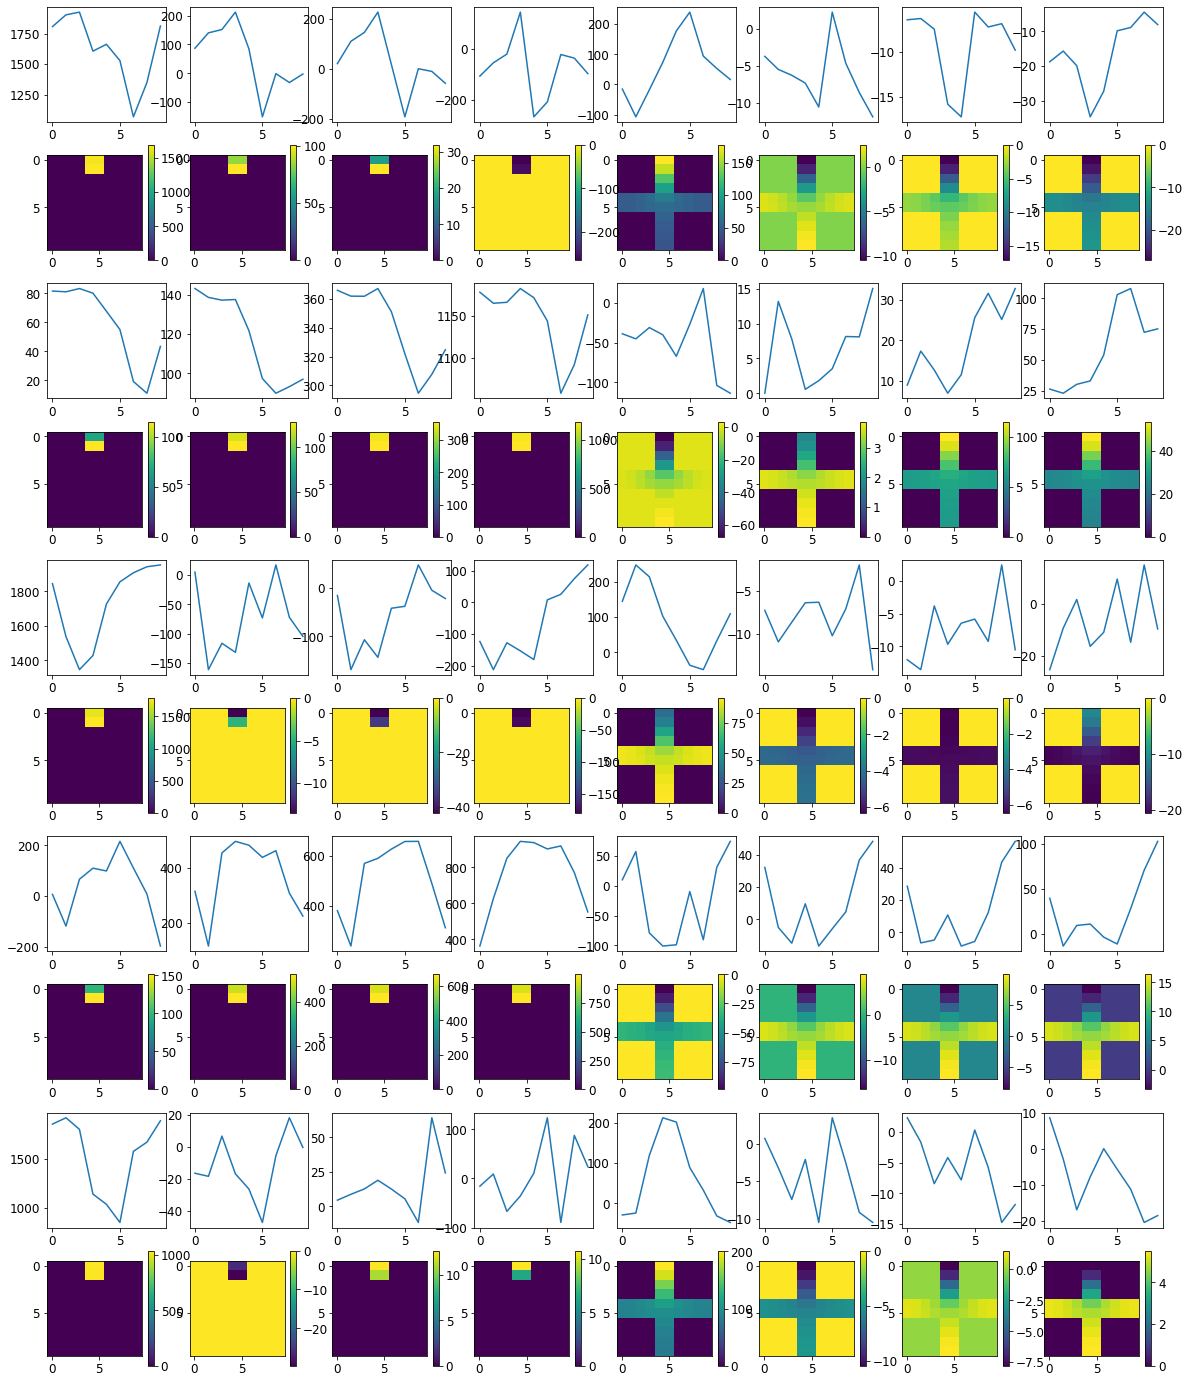

Loss: 


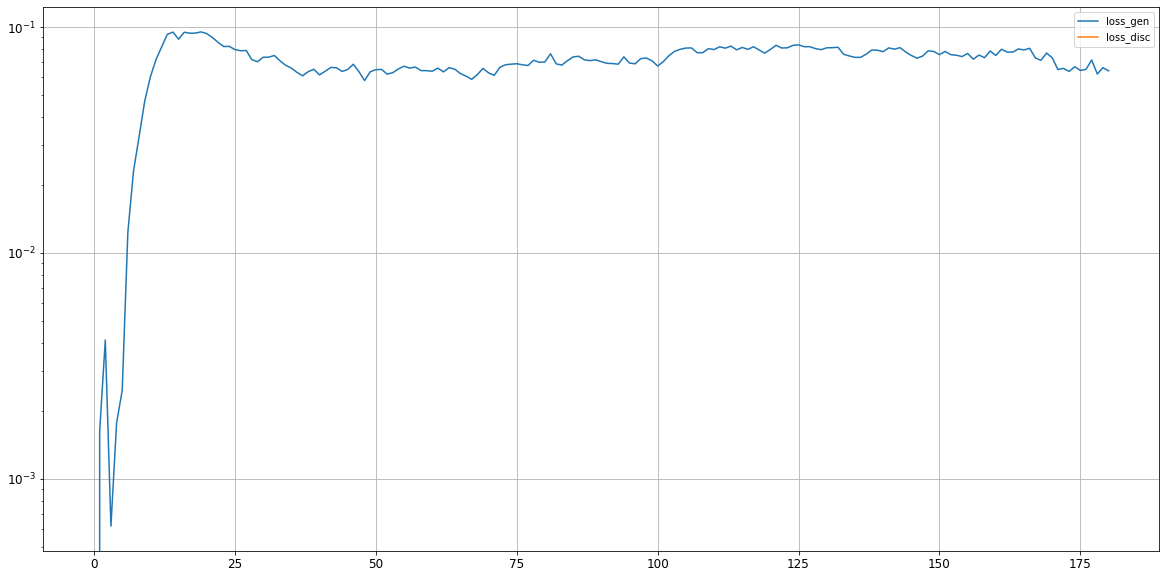

Epoch 181/400
critic loss: -0.013895 - generator loss: 0.064813 - 40s
Epoch 182/400
critic loss: -0.014862 - generator loss: 0.063258 - 38s
Epoch 183/400
critic loss: -0.012765 - generator loss: 0.061814 - 39s
Epoch 184/400
critic loss: -0.012092 - generator loss: 0.059872 - 40s
Epoch 185/400
critic loss: -0.012241 - generator loss: 0.053210 - 38s
Epoch 186/400
critic loss: -0.014169 - generator loss: 0.056215 - 39s
Epoch 187/400
critic loss: -0.013037 - generator loss: 0.058033 - 39s
Epoch 188/400
critic loss: -0.012126 - generator loss: 0.059392 - 39s
Epoch 189/400
critic loss: -0.013297 - generator loss: 0.058690 - 39s
Epoch 190/400
critic loss: -0.012057 - generator loss: 0.057344 - 39s
Epoch 191/400
critic loss: -0.013253 - generator loss: 0.054517 - 39s
Epoch 192/400
critic loss: -0.012519 - generator loss: 0.053807 - 38s
Epoch 193/400
critic loss: -0.013446 - generator loss: 0.052934 - 40s
Epoch 194/400
critic loss: -0.011293 - generator loss: 0.050727 - 39s
Epoch 195/400
critic

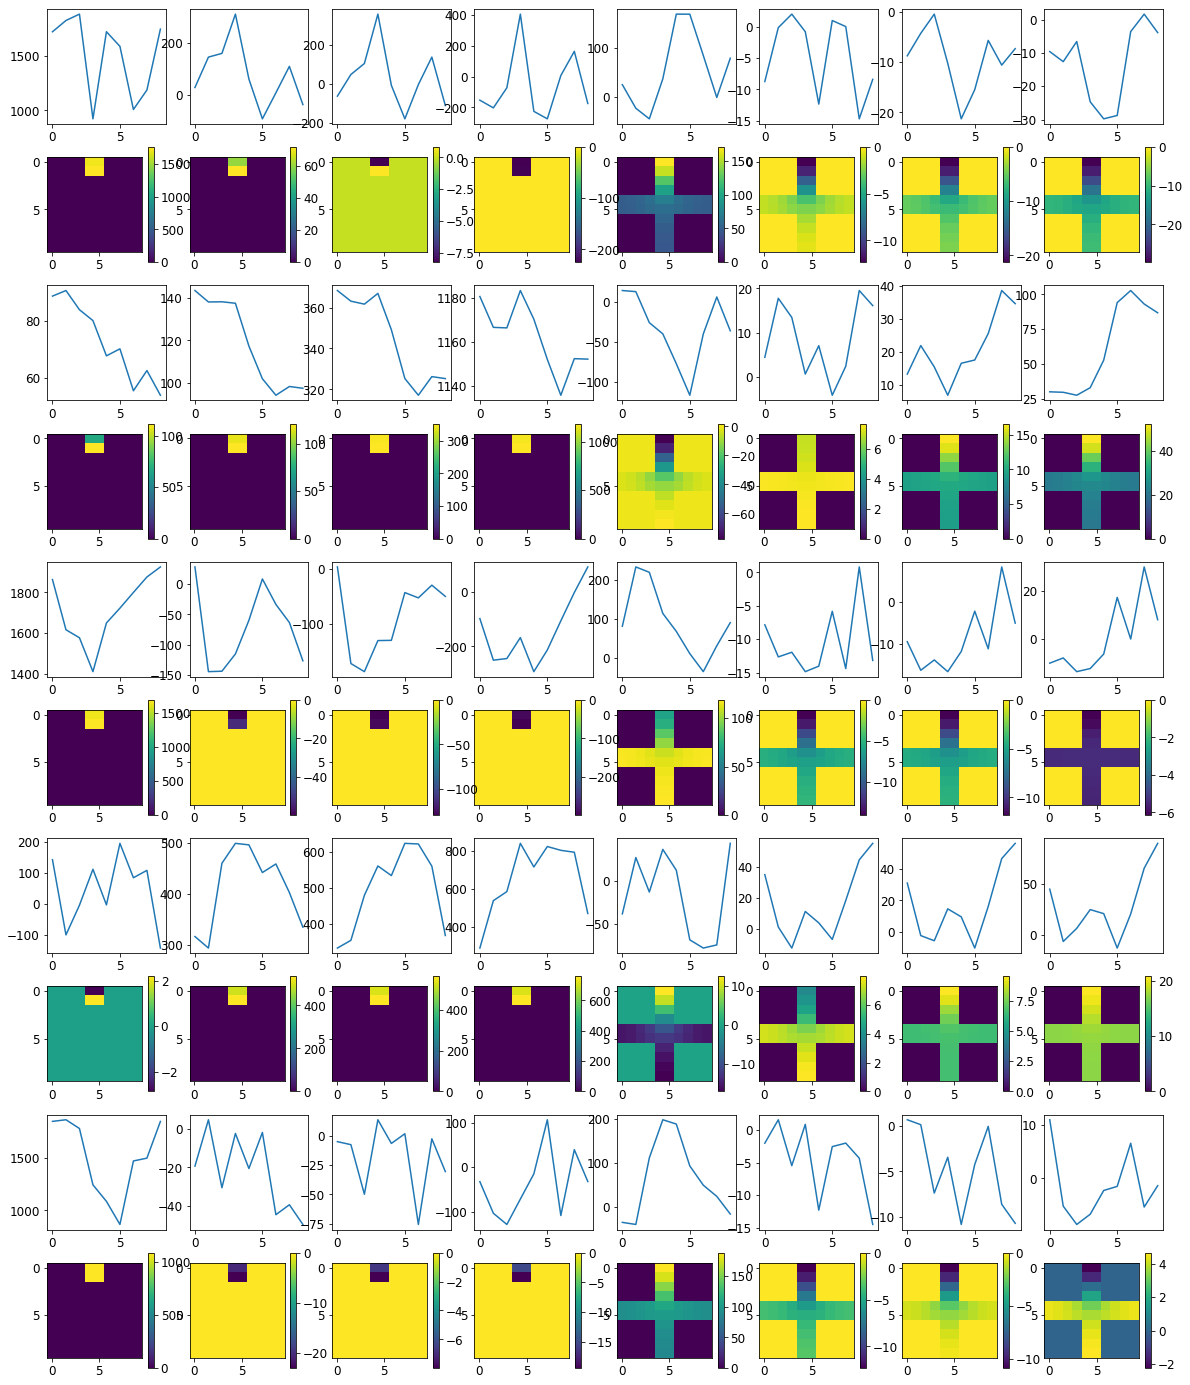

Loss: 


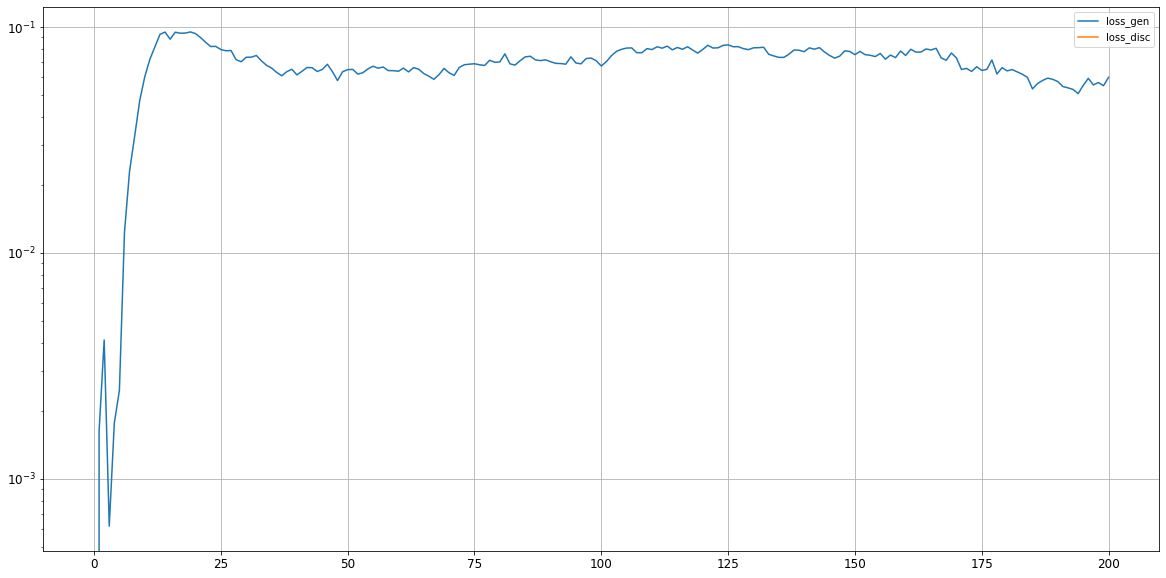

Epoch 201/400
critic loss: -0.012507 - generator loss: 0.053279 - 39s
Epoch 202/400
critic loss: -0.011994 - generator loss: 0.053766 - 39s
Epoch 203/400
critic loss: -0.011650 - generator loss: 0.052910 - 38s
Epoch 204/400
critic loss: -0.011694 - generator loss: 0.049568 - 39s
Epoch 205/400
critic loss: -0.013138 - generator loss: 0.051501 - 39s
Epoch 206/400
critic loss: -0.011981 - generator loss: 0.056247 - 39s
Epoch 207/400
critic loss: -0.012083 - generator loss: 0.045247 - 39s
Epoch 208/400
critic loss: -0.009632 - generator loss: 0.056539 - 40s
Epoch 209/400
critic loss: -0.010820 - generator loss: 0.050384 - 38s
Epoch 210/400
critic loss: -0.011561 - generator loss: 0.051528 - 39s
Epoch 211/400
critic loss: -0.011668 - generator loss: 0.051438 - 39s
Epoch 212/400
critic loss: -0.011386 - generator loss: 0.042998 - 39s
Epoch 213/400
critic loss: -0.010824 - generator loss: 0.047260 - 39s
Epoch 214/400
critic loss: -0.010950 - generator loss: 0.045010 - 39s
Epoch 215/400
critic

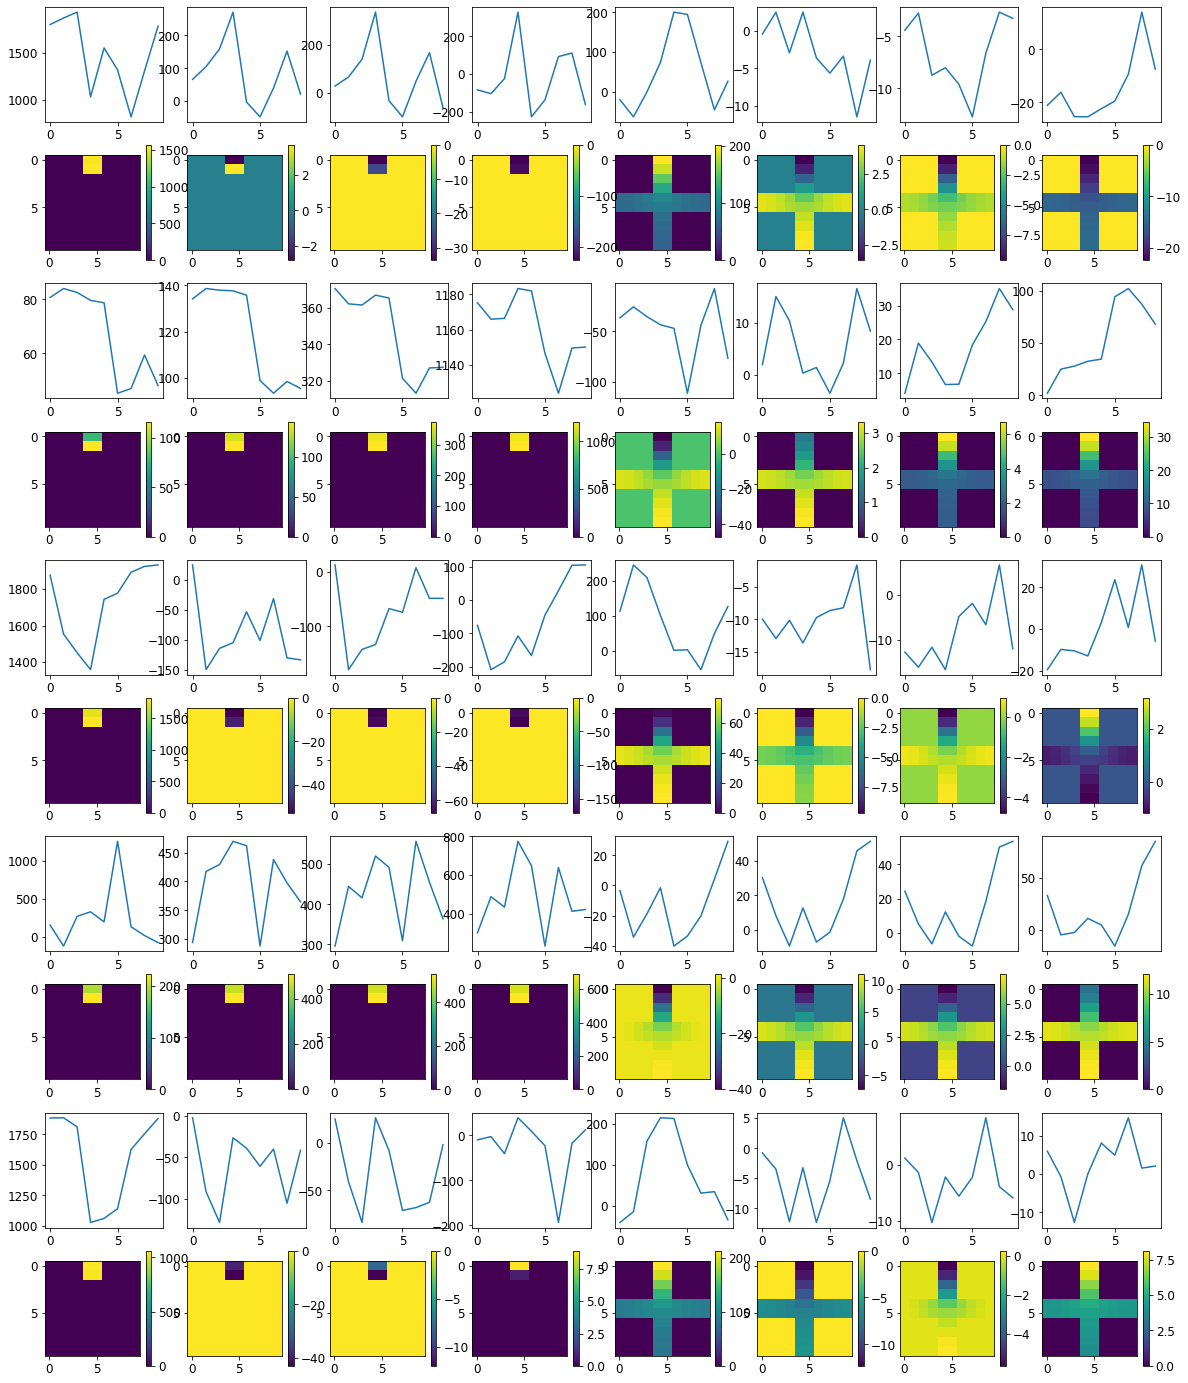

Loss: 


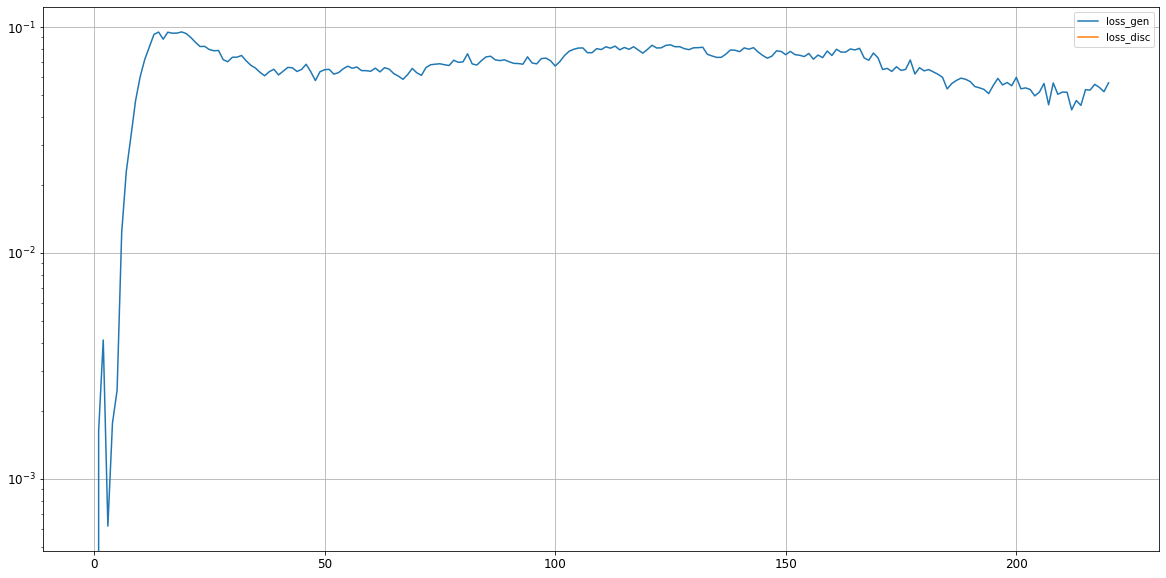

Epoch 221/400
critic loss: -0.011309 - generator loss: 0.048205 - 40s
Epoch 222/400
critic loss: -0.008945 - generator loss: 0.047429 - 38s
Epoch 223/400
critic loss: -0.011639 - generator loss: 0.047767 - 39s
Epoch 224/400
critic loss: -0.010307 - generator loss: 0.048685 - 39s
Epoch 225/400
critic loss: -0.011046 - generator loss: 0.048645 - 39s
Epoch 226/400
critic loss: -0.010333 - generator loss: 0.052015 - 40s
Epoch 227/400
critic loss: -0.010504 - generator loss: 0.052945 - 39s
Epoch 228/400
critic loss: -0.011473 - generator loss: 0.047049 - 38s
Epoch 229/400
critic loss: -0.010653 - generator loss: 0.044660 - 39s
Epoch 230/400
critic loss: -0.007643 - generator loss: 0.050042 - 39s
Epoch 231/400
critic loss: -0.009823 - generator loss: 0.042609 - 38s
Epoch 232/400
critic loss: -0.009551 - generator loss: 0.037673 - 39s
Epoch 233/400
critic loss: -0.010580 - generator loss: 0.038426 - 39s
Epoch 234/400
critic loss: -0.011057 - generator loss: 0.041391 - 39s
Epoch 235/400
critic

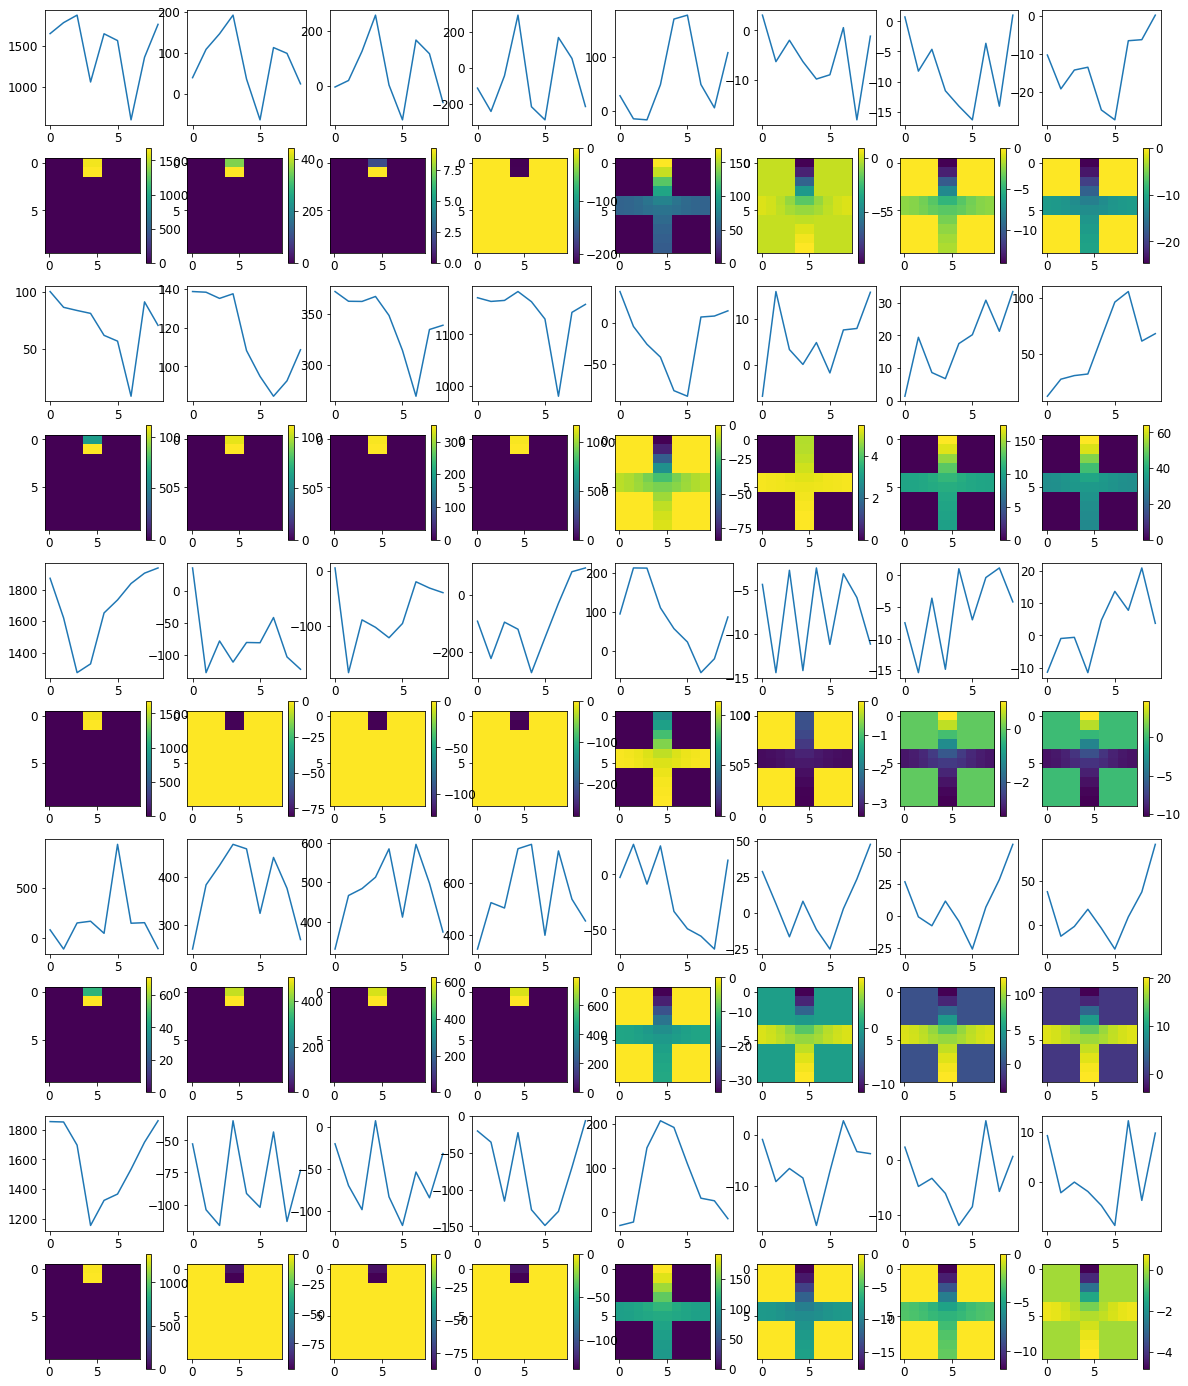

Loss: 


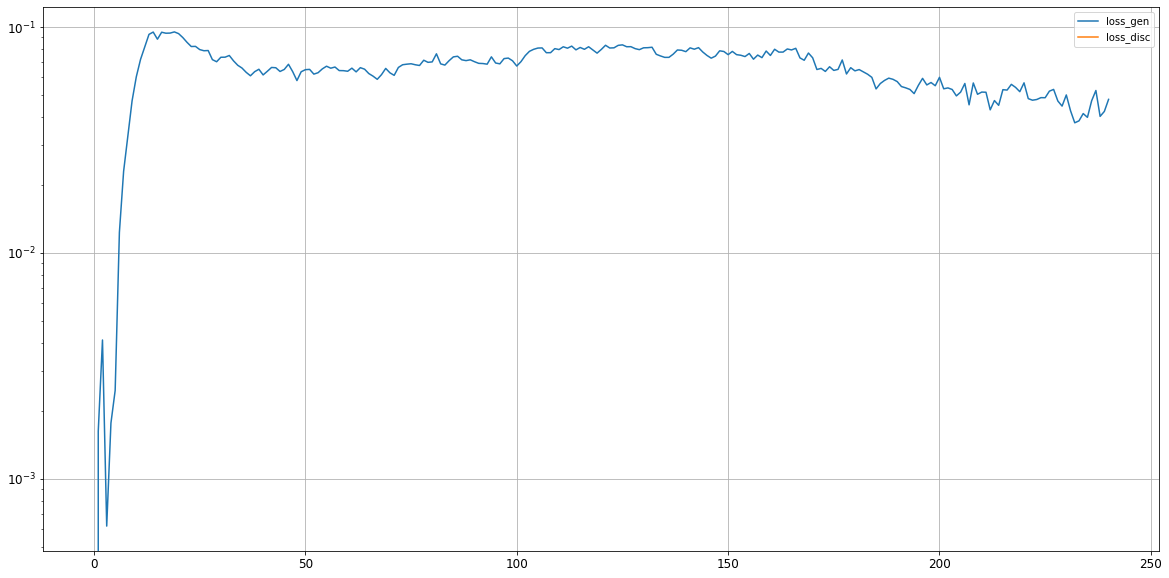

Epoch 241/400
critic loss: -0.009273 - generator loss: 0.039049 - 37s
Epoch 242/400
critic loss: -0.011627 - generator loss: 0.042474 - 39s
Epoch 243/400
critic loss: -0.010506 - generator loss: 0.040888 - 39s
Epoch 244/400
critic loss: -0.009138 - generator loss: 0.043693 - 39s
Epoch 245/400
critic loss: -0.009352 - generator loss: 0.047863 - 39s
Epoch 246/400
critic loss: -0.010187 - generator loss: 0.040759 - 39s
Epoch 247/400
critic loss: -0.010995 - generator loss: 0.043036 - 39s
Epoch 248/400
critic loss: -0.010080 - generator loss: 0.049304 - 39s
Epoch 249/400
critic loss: -0.009296 - generator loss: 0.042619 - 39s
Epoch 250/400
critic loss: -0.009531 - generator loss: 0.040067 - 39s
Epoch 251/400
critic loss: -0.010156 - generator loss: 0.040477 - 40s
Epoch 252/400
critic loss: -0.010222 - generator loss: 0.042359 - 39s
Epoch 253/400
critic loss: -0.008529 - generator loss: 0.052405 - 38s
Epoch 254/400
critic loss: -0.010222 - generator loss: 0.041122 - 39s
Epoch 255/400
critic

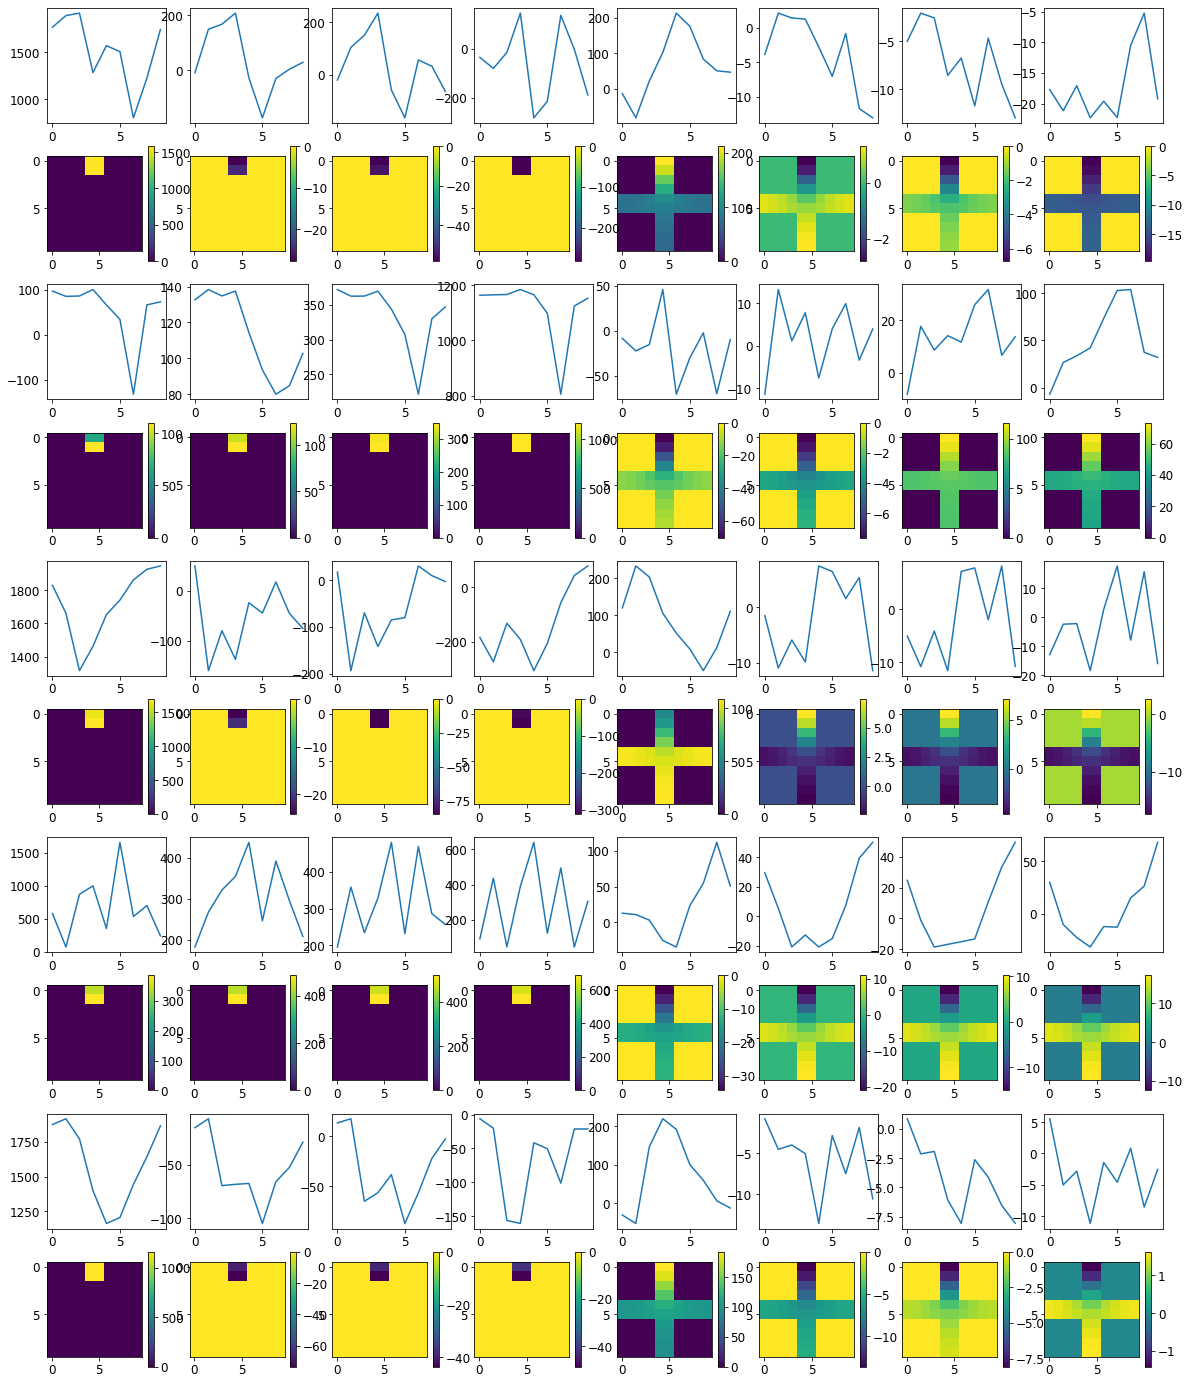

Loss: 


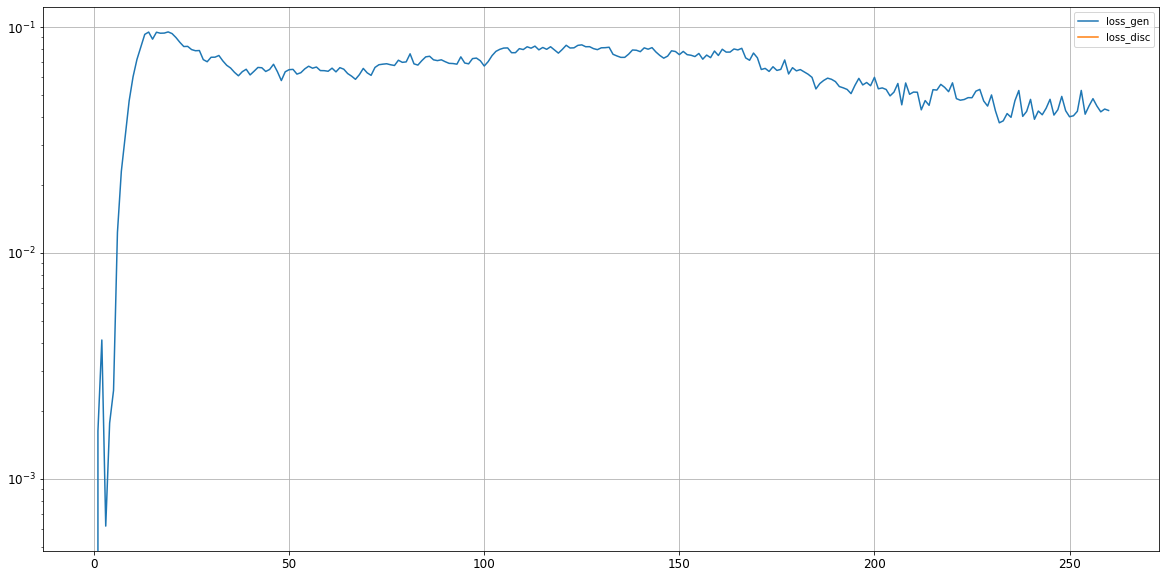

Epoch 261/400
critic loss: -0.010755 - generator loss: 0.042406 - 38s
Epoch 262/400
critic loss: -0.009370 - generator loss: 0.045319 - 39s
Epoch 263/400
critic loss: -0.009174 - generator loss: 0.040797 - 39s
Epoch 264/400
critic loss: -0.008881 - generator loss: 0.041433 - 38s
Epoch 265/400
critic loss: -0.008361 - generator loss: 0.033722 - 40s
Epoch 266/400
critic loss: -0.008553 - generator loss: 0.031807 - 39s
Epoch 267/400
critic loss: -0.008526 - generator loss: 0.053282 - 39s
Epoch 268/400
critic loss: -0.009185 - generator loss: 0.052900 - 38s
Epoch 269/400
critic loss: -0.009648 - generator loss: 0.042912 - 39s
Epoch 270/400
critic loss: -0.008295 - generator loss: 0.041856 - 39s
Epoch 271/400
critic loss: -0.008615 - generator loss: 0.042687 - 39s
Epoch 272/400
critic loss: -0.007940 - generator loss: 0.040929 - 39s
Epoch 273/400
critic loss: -0.009174 - generator loss: 0.051274 - 39s
Epoch 274/400
critic loss: -0.008309 - generator loss: 0.042488 - 39s
Epoch 275/400
critic

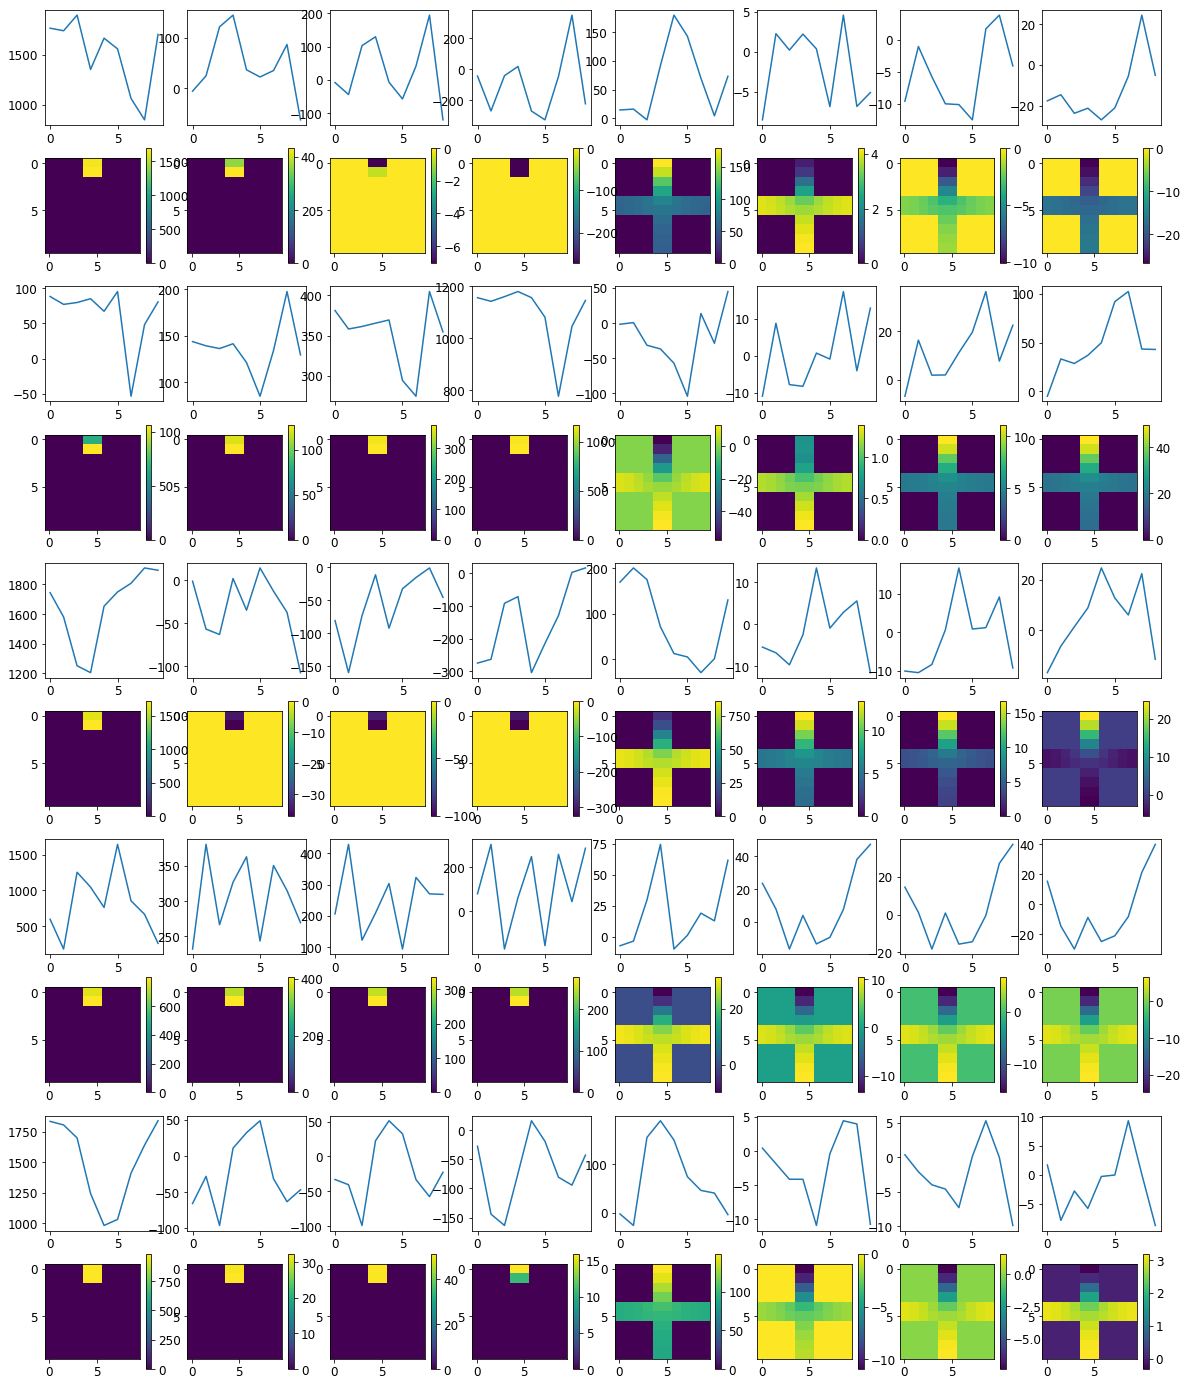

Loss: 


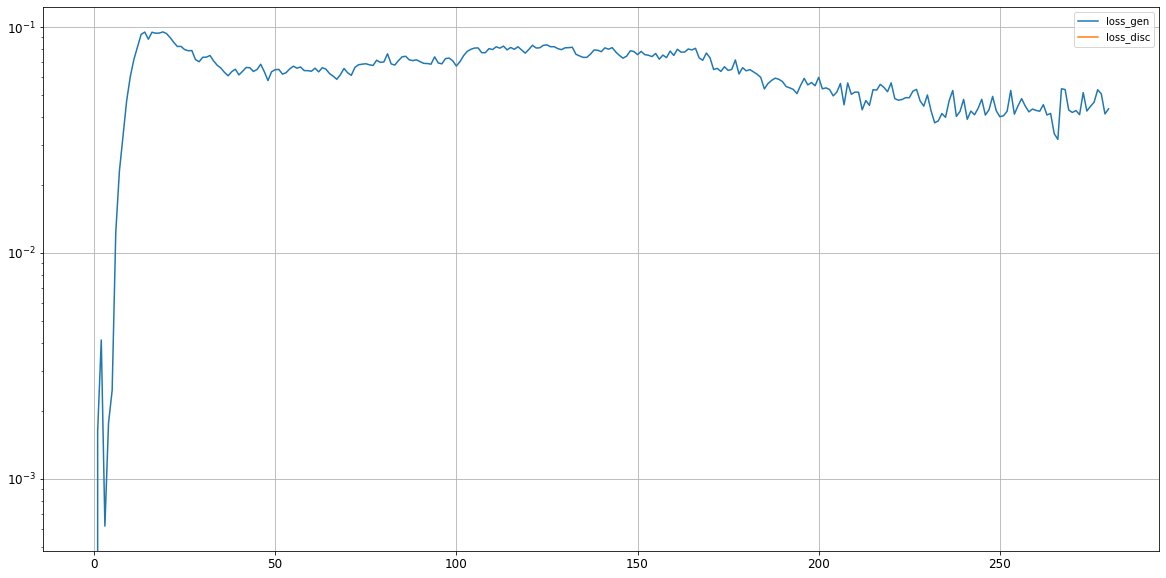

Epoch 281/400
critic loss: -0.009005 - generator loss: 0.043473 - 38s
Epoch 282/400
critic loss: -0.008301 - generator loss: 0.045983 - 38s
Epoch 283/400
critic loss: -0.008321 - generator loss: 0.052729 - 38s
Epoch 284/400
critic loss: -0.008639 - generator loss: 0.057988 - 40s
Epoch 285/400
critic loss: -0.008372 - generator loss: 0.047192 - 39s
Epoch 286/400
critic loss: -0.006857 - generator loss: 0.050993 - 39s
Epoch 287/400
critic loss: -0.007044 - generator loss: 0.052948 - 39s
Epoch 288/400
critic loss: -0.007816 - generator loss: 0.053132 - 39s
Epoch 289/400
critic loss: -0.009247 - generator loss: 0.052985 - 39s
Epoch 290/400
critic loss: -0.007563 - generator loss: 0.045483 - 40s
Epoch 291/400
critic loss: -0.007361 - generator loss: 0.054076 - 39s
Epoch 292/400
critic loss: -0.008161 - generator loss: 0.049318 - 39s
Epoch 293/400
critic loss: -0.006526 - generator loss: 0.048015 - 38s
Epoch 294/400
critic loss: -0.008851 - generator loss: 0.048745 - 38s
Epoch 295/400
critic

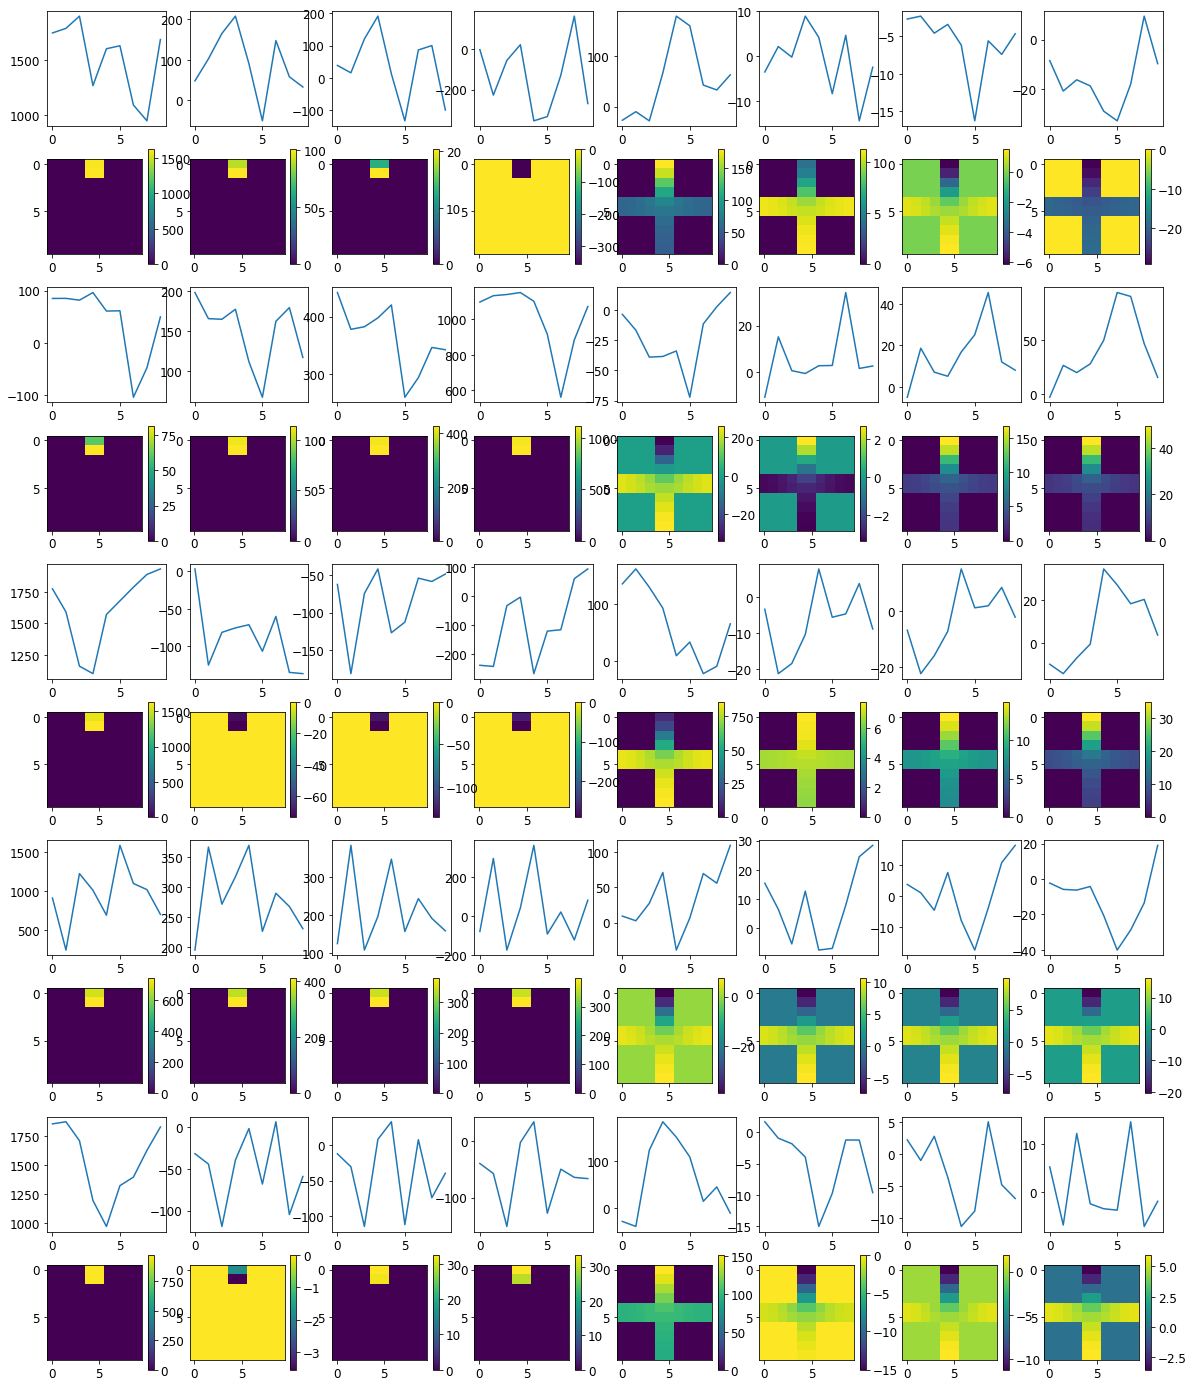

Loss: 


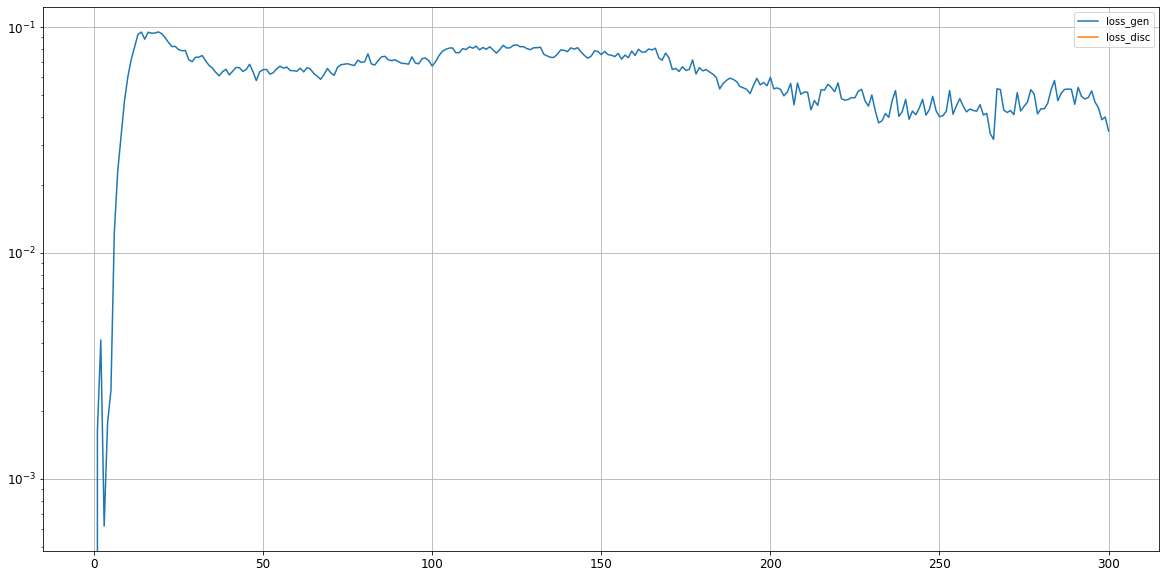

Epoch 301/400
critic loss: -0.007318 - generator loss: 0.036305 - 39s
Epoch 302/400
critic loss: -0.008217 - generator loss: 0.038407 - 40s
Epoch 303/400
critic loss: -0.007528 - generator loss: 0.049935 - 39s
Epoch 304/400
critic loss: -0.007727 - generator loss: 0.044960 - 40s
Epoch 305/400
critic loss: -0.007853 - generator loss: 0.036746 - 39s
Epoch 306/400
critic loss: -0.007063 - generator loss: 0.047537 - 39s
Epoch 307/400
critic loss: -0.008292 - generator loss: 0.046089 - 39s
Epoch 308/400
critic loss: -0.008228 - generator loss: 0.038894 - 39s
Epoch 309/400
critic loss: -0.007142 - generator loss: 0.045607 - 39s
Epoch 310/400
critic loss: -0.007572 - generator loss: 0.039122 - 40s
Epoch 311/400
critic loss: -0.007584 - generator loss: 0.035226 - 39s
Epoch 312/400
critic loss: -0.007391 - generator loss: 0.047903 - 39s
Epoch 313/400
critic loss: -0.007357 - generator loss: 0.042957 - 39s
Epoch 314/400
critic loss: -0.007170 - generator loss: 0.042078 - 39s
Epoch 315/400
critic

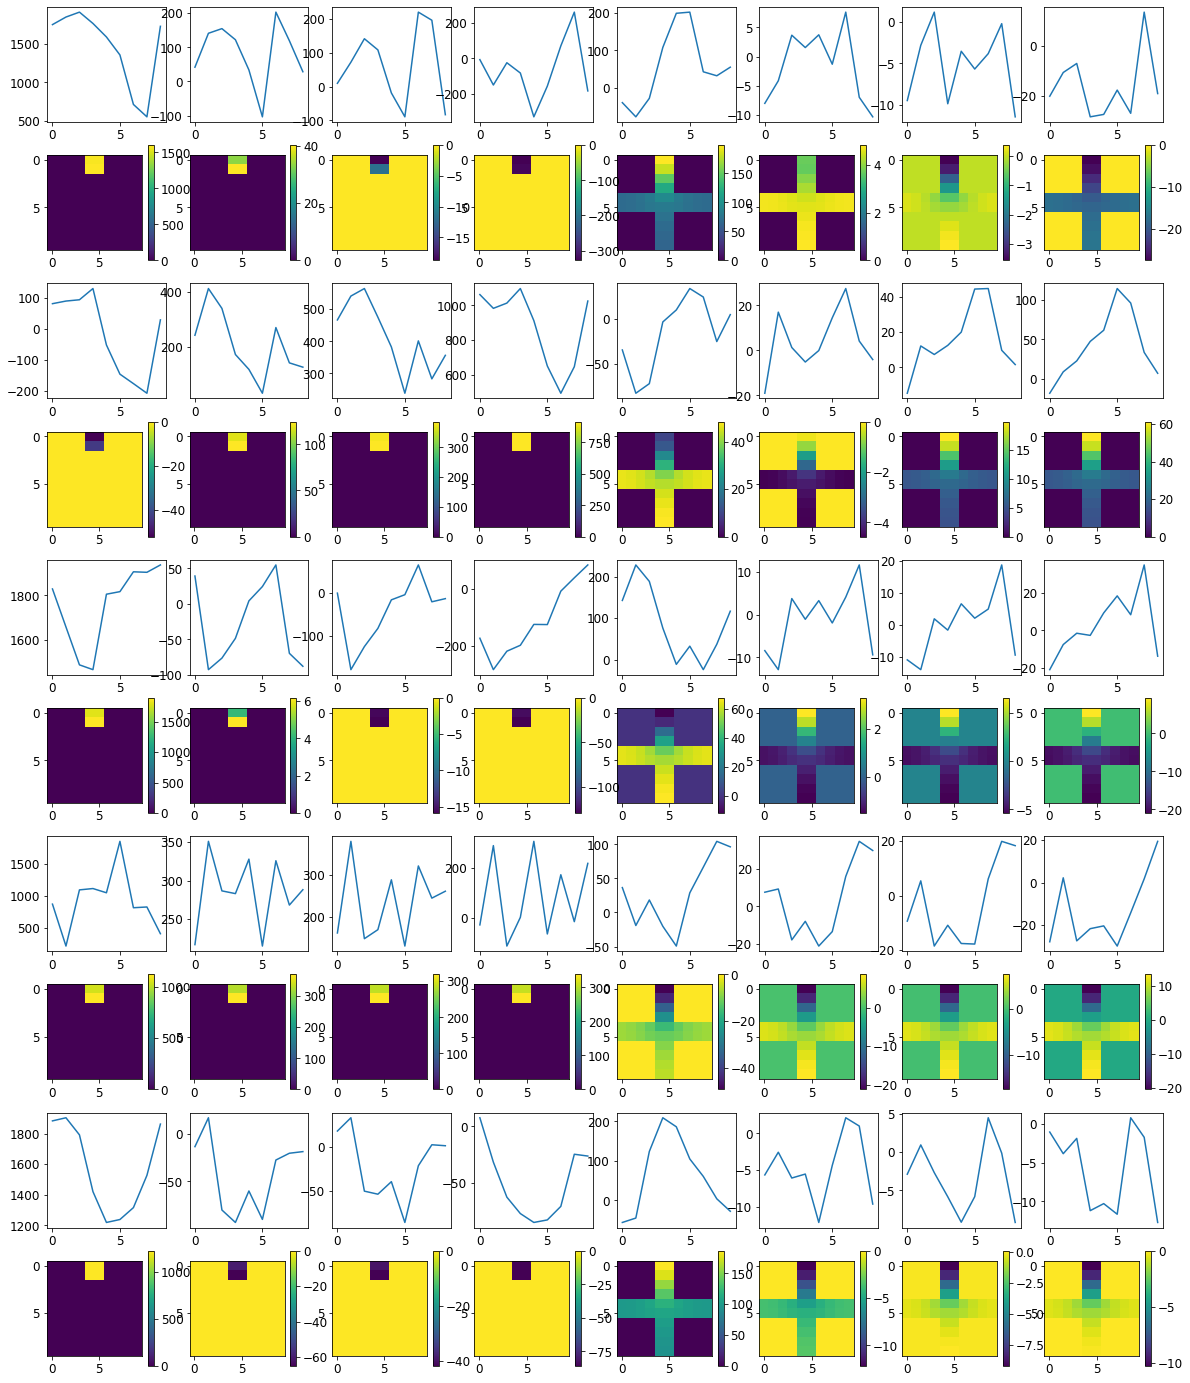

Loss: 


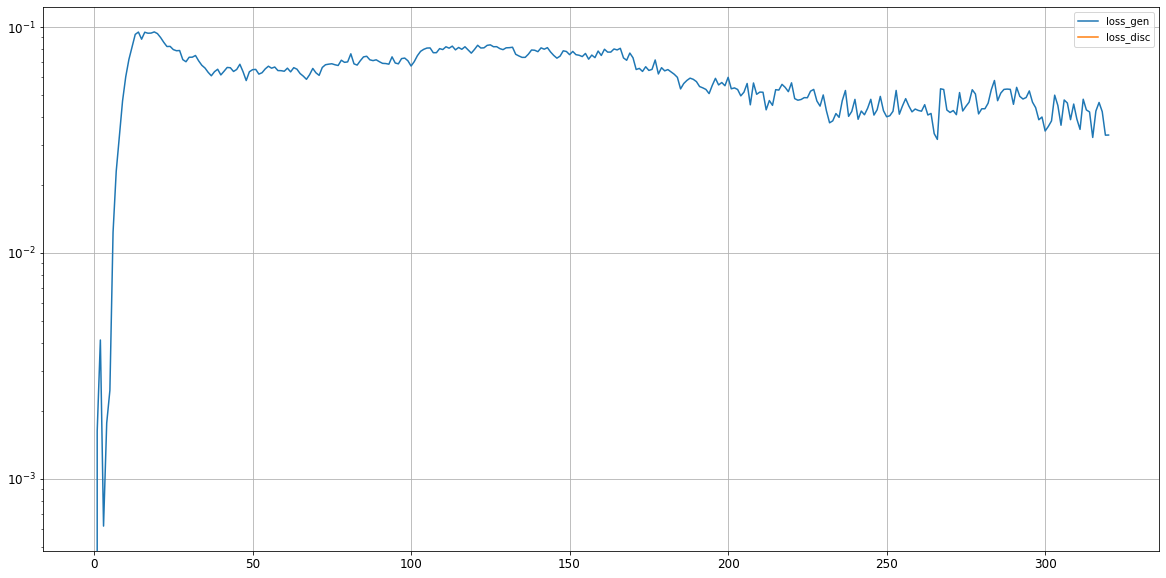

Epoch 321/400
critic loss: -0.007181 - generator loss: 0.036001 - 39s
Epoch 322/400
critic loss: -0.008273 - generator loss: 0.037441 - 40s
Epoch 323/400
critic loss: -0.007461 - generator loss: 0.028519 - 40s
Epoch 324/400
critic loss: -0.006245 - generator loss: 0.052049 - 38s
Epoch 325/400
critic loss: -0.006518 - generator loss: 0.046261 - 39s
Epoch 326/400
critic loss: -0.006361 - generator loss: 0.046563 - 40s
Epoch 327/400
critic loss: -0.007313 - generator loss: 0.039130 - 38s
Epoch 328/400
critic loss: -0.006974 - generator loss: 0.033806 - 39s
Epoch 329/400
critic loss: -0.006482 - generator loss: 0.032894 - 39s
Epoch 330/400
critic loss: -0.006388 - generator loss: 0.035209 - 39s
Epoch 331/400
critic loss: -0.006941 - generator loss: 0.031699 - 39s
Epoch 332/400
critic loss: -0.007155 - generator loss: 0.035751 - 39s
Epoch 333/400
critic loss: -0.006542 - generator loss: 0.025670 - 39s
Epoch 334/400
critic loss: -0.006302 - generator loss: 0.037644 - 40s
Epoch 335/400
critic

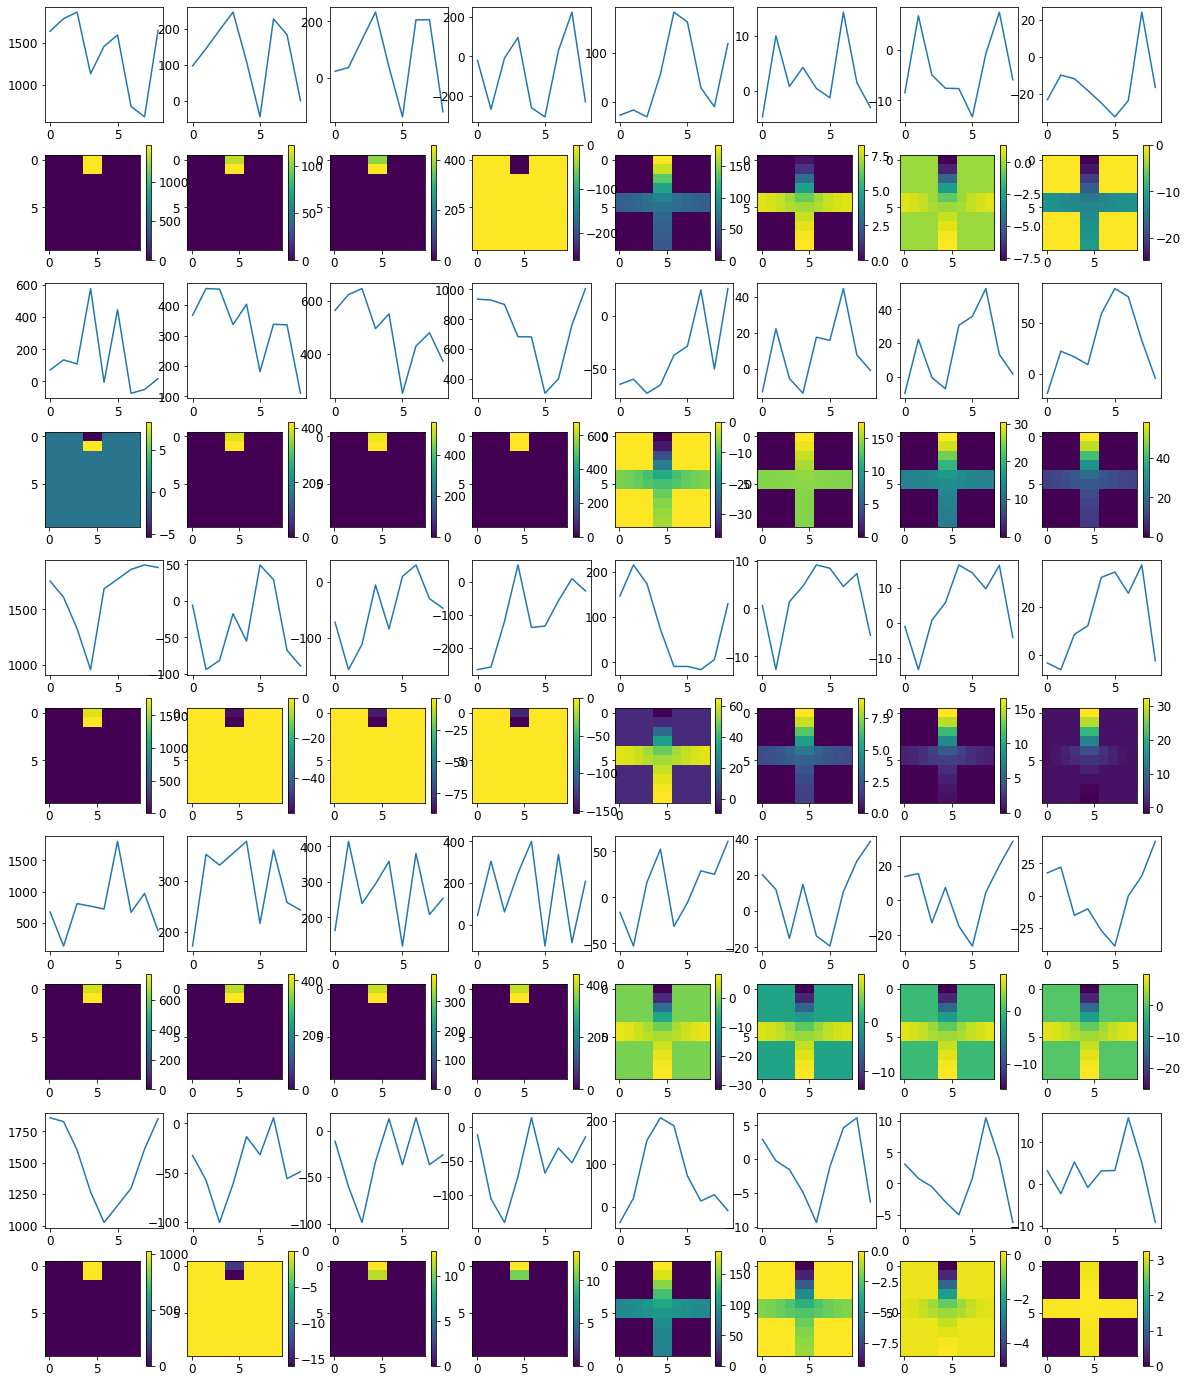

Loss: 


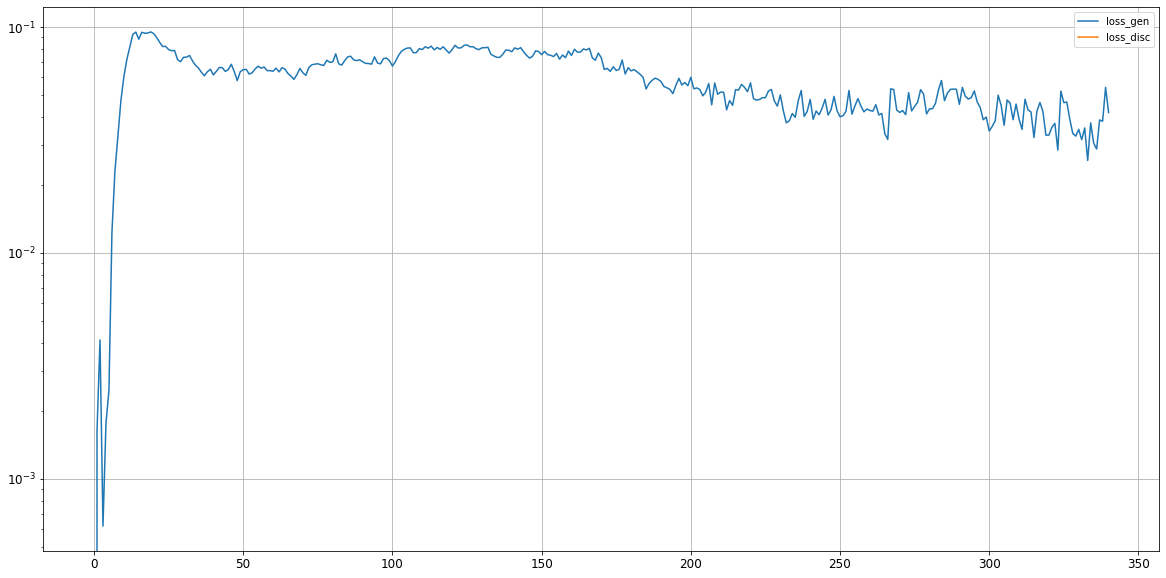

Epoch 341/400
critic loss: -0.006732 - generator loss: 0.048337 - 39s
Epoch 342/400
critic loss: -0.007671 - generator loss: 0.046084 - 38s
Epoch 343/400
critic loss: -0.006465 - generator loss: 0.041603 - 40s
Epoch 344/400
critic loss: -0.004910 - generator loss: 0.038320 - 40s
Epoch 345/400
critic loss: -0.007000 - generator loss: 0.040947 - 39s
Epoch 346/400
critic loss: -0.006621 - generator loss: 0.033628 - 39s
Epoch 347/400
critic loss: -0.003826 - generator loss: 0.034181 - 42s
Epoch 348/400
critic loss: -0.006228 - generator loss: 0.028638 - 42s
Epoch 349/400
critic loss: -0.005939 - generator loss: 0.035350 - 42s
Epoch 350/400
critic loss: -0.006169 - generator loss: 0.030216 - 42s
Epoch 351/400
critic loss: -0.005419 - generator loss: 0.026479 - 43s
Epoch 352/400
critic loss: -0.006785 - generator loss: 0.026017 - 43s
Epoch 353/400
critic loss: -0.006526 - generator loss: 0.042883 - 43s
Epoch 354/400
critic loss: -0.006184 - generator loss: 0.035486 - 40s
Epoch 355/400
critic

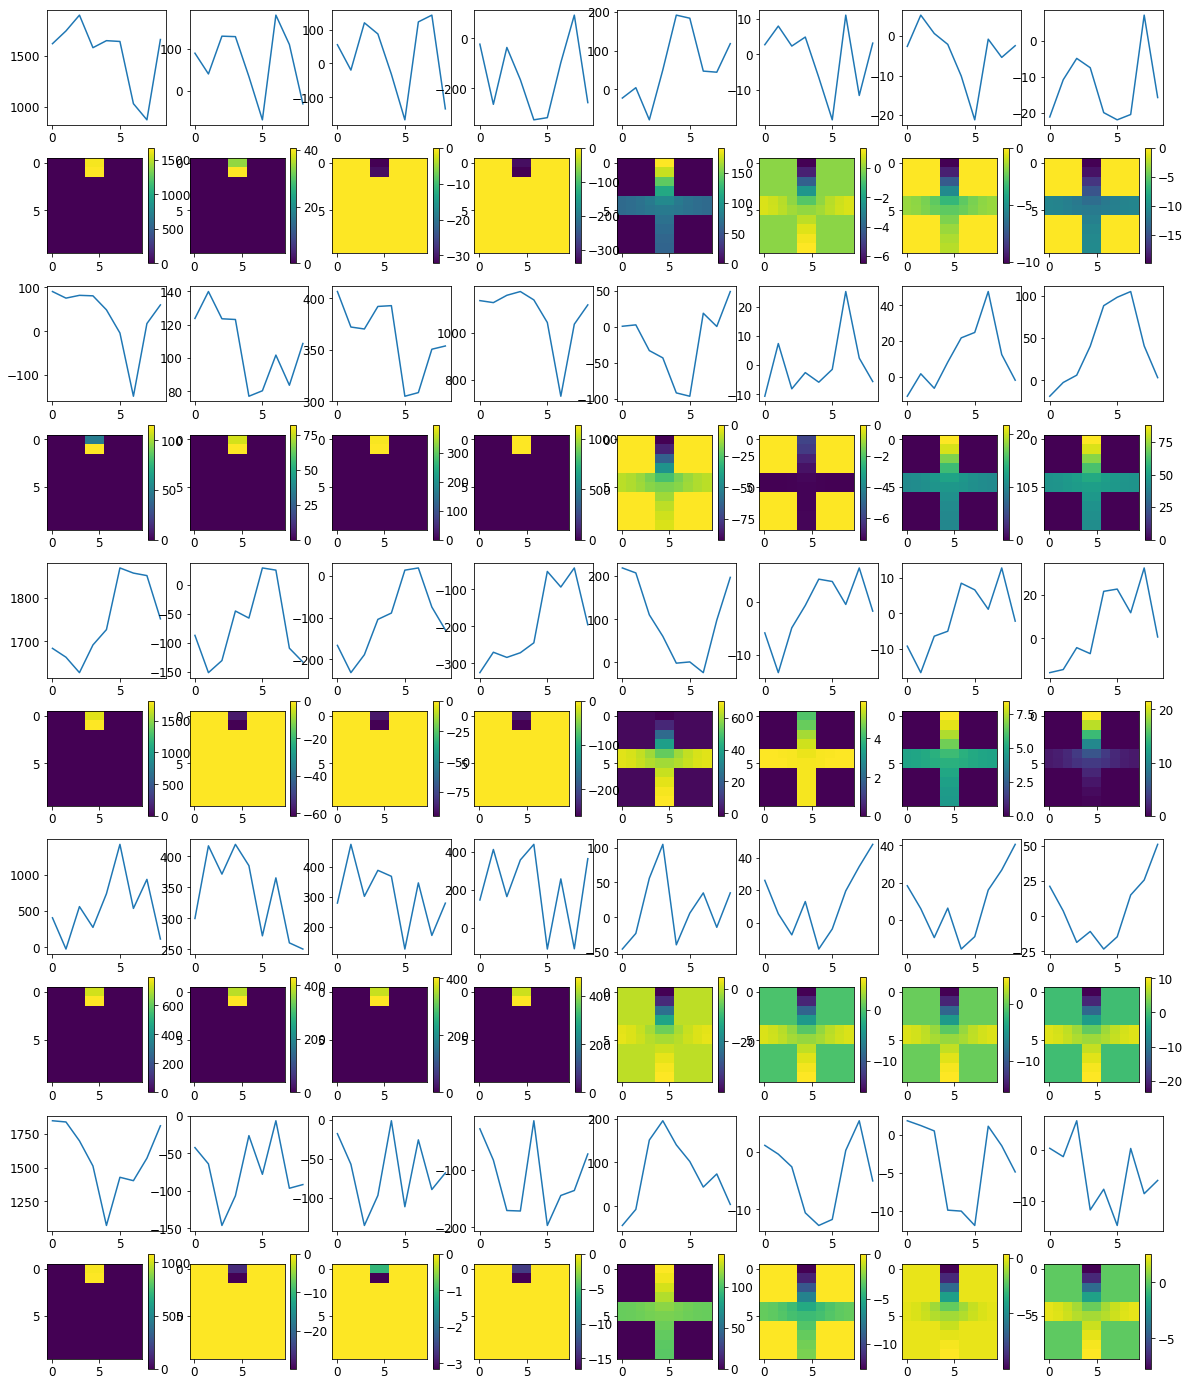

Loss: 


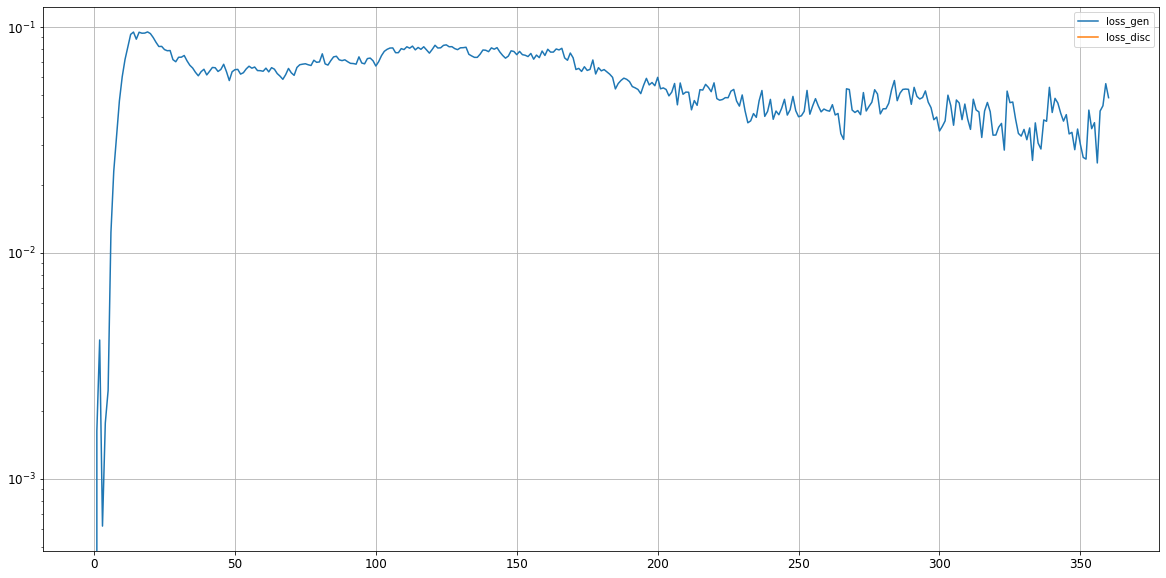

Epoch 361/400
critic loss: -0.006371 - generator loss: 0.046093 - 39s
Epoch 362/400
critic loss: -0.004334 - generator loss: 0.046922 - 39s
Epoch 363/400
critic loss: -0.005588 - generator loss: 0.041609 - 40s
Epoch 364/400
critic loss: -0.005694 - generator loss: 0.041146 - 40s
Epoch 365/400
critic loss: -0.006823 - generator loss: 0.043561 - 40s
Epoch 366/400
critic loss: -0.006574 - generator loss: 0.056823 - 38s
Epoch 367/400
critic loss: -0.006347 - generator loss: 0.047872 - 39s
Epoch 368/400
critic loss: -0.006206 - generator loss: 0.045573 - 39s
Epoch 369/400
critic loss: -0.006452 - generator loss: 0.044843 - 39s
Epoch 370/400
critic loss: -0.005508 - generator loss: 0.029685 - 40s
Epoch 371/400
critic loss: -0.006670 - generator loss: 0.031516 - 39s
Epoch 372/400
critic loss: -0.005519 - generator loss: 0.037913 - 39s
Epoch 373/400
critic loss: -0.006551 - generator loss: 0.029415 - 39s
Epoch 374/400
critic loss: -0.006128 - generator loss: 0.034951 - 40s
Epoch 375/400
critic

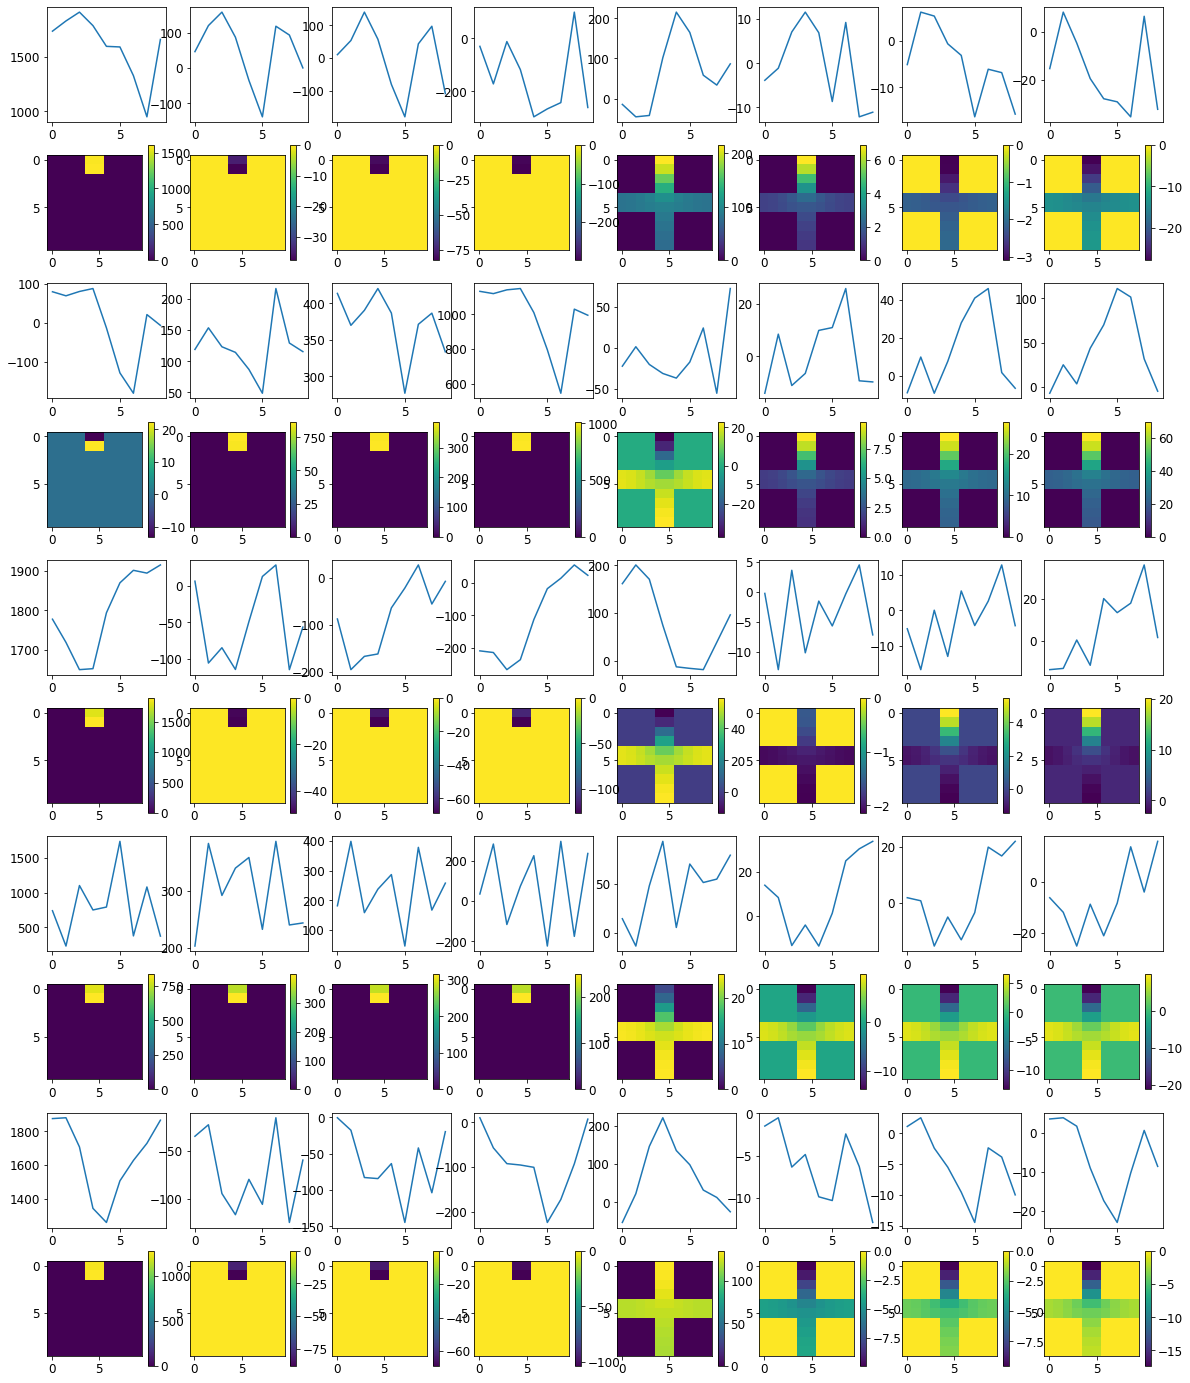

Loss: 


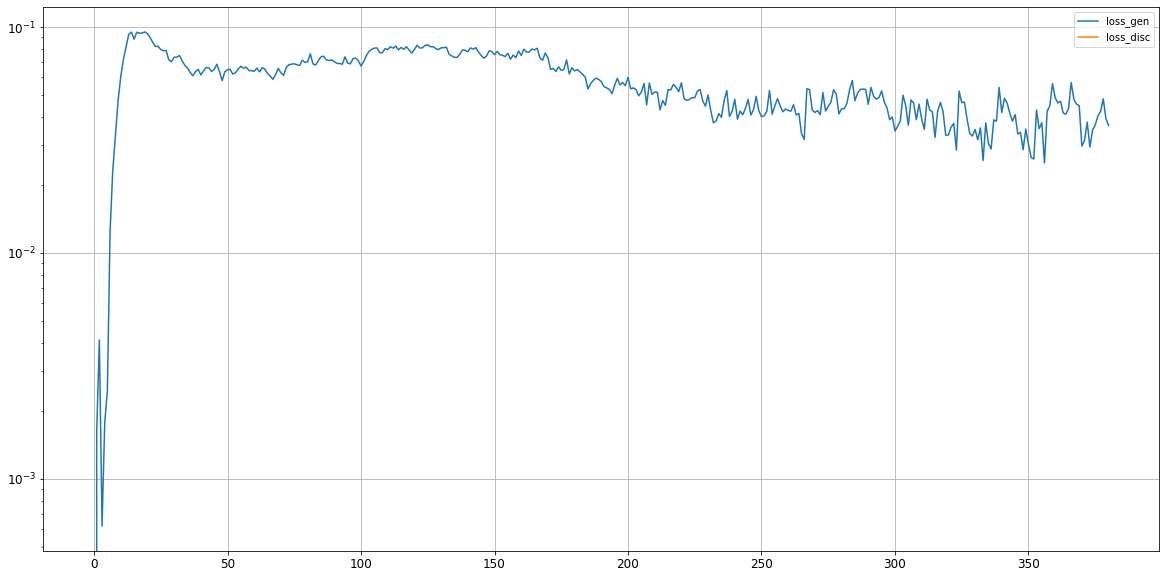

Epoch 381/400
critic loss: -0.005683 - generator loss: 0.047707 - 41s
Epoch 382/400
critic loss: -0.005417 - generator loss: 0.039432 - 43s
Epoch 383/400
critic loss: -0.006214 - generator loss: 0.042850 - 41s
Epoch 384/400
critic loss: -0.005285 - generator loss: 0.040483 - 40s
Epoch 385/400
critic loss: -0.004628 - generator loss: 0.050152 - 39s
Epoch 386/400
critic loss: -0.005584 - generator loss: 0.034511 - 40s
Epoch 387/400
critic loss: -0.005600 - generator loss: 0.040430 - 40s
Epoch 388/400
critic loss: -0.005277 - generator loss: 0.040572 - 40s
Epoch 389/400
critic loss: -0.005722 - generator loss: 0.051094 - 39s
Epoch 390/400
critic loss: -0.005833 - generator loss: 0.045415 - 39s
Epoch 391/400
critic loss: -0.003851 - generator loss: 0.033881 - 40s
Epoch 392/400
critic loss: -0.005122 - generator loss: 0.044197 - 39s
Epoch 393/400
critic loss: -0.004580 - generator loss: 0.043266 - 39s
Epoch 394/400
critic loss: -0.004478 - generator loss: 0.036526 - 41s
Epoch 395/400
critic

In [37]:
hist = train(train_dataset, epochs=400)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

In [ ]:
#from tensorflow.keras.models import load_model
import joblib
joblib.dump(scaler, "scaler-tfex.pkl")
gan.save("gan-tfex.h5")

In [3]:
np.random.seed(10)
tf.random.set_seed(10)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated[X_generated<0.0] = 0.0

NameError: name 'np' is not defined

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[2930:3020,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[0,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[2932,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

In [ ]:
npredict = 5
noise = tf.random.normal(shape=[npredict, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(npredict*ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, len(groups)*nl*nc)
fig, ax = plt.subplots(npredict*2,len(groups), figsize=[20,npredict*5])
for j in range(npredict):
    for i, group in enumerate(groups):
        for k in range(0,10,10): 
            ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
    for i, group in enumerate(groups):
        im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
        fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
